# Desafio Grupo ZAP - 07/2019

## Objetivo
 - Um anúncio no portal é composto por diversas características do imóvel, como tamanho, número de quartos, etc. Uma das principais características do imóvel é o seu preço de venda, identificado pelo campo price que, por sua vez, está dentro do campo princingInfos.
 - O objetivo é criar uma maneira automática de estimar um preço de venda para os apartamentos.

## Entregas
- Arquivo csv com os preços dos anúncios com os campos: [id, price]
- Explicação da solução
- Código fonte da solução
- Respostas (com insumos para suporte) para as seguintes questões:
    - Você utilizaria a métrica escolhida para seleção de modelo também para comunicar os resultados para usuários e stakeholders internos? Em caso negativo, qual outra métrica você utilizaria nesse caso?
    - Em quais bairros ou em quais faixas de preço o seu modelo performa melhor?
    - Se você tivesse que estimar o valor dos imóveis com apenas 3 campos, quais seriam eles?
    - Como você vislumbra colocar a sua solução em produção?

# Processo que será seguido

In [1]:
from IPython.display import Image
Image(url = 'images/processo.png')

# Importando as bibliotecas que serão utilizadas neste projeto

In [2]:
# Importando bibliotecas que serao utilizadas neste projeto
import pandas as pd
import json
from pandas.io.json import json_normalize
import numpy as np
import seaborn as sns
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

# Models
from xgboost import XGBRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from mlxtend.regressor import StackingCVRegressor
from lightgbm import LGBMRegressor
import lightgbm as lgb
import xgboost as XGB
from sklearn.cluster import KMeans

# Stats
from scipy import stats
from scipy.stats import skew, norm
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

# Misc
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from functools import partial
from hyperopt import fmin, hp, tpe, Trials, space_eval
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from IPython.display import Image

#!pip install folium
import folium
from folium import plugins

#!pip install pandasql
import pandasql as ps

# Ignore useless warnings
import warnings
warnings.filterwarnings(action="ignore")
pd.options.display.max_seq_items = 8000
pd.options.display.max_rows = 8000
pd.set_option('display.max_columns', None)

import pickle
import datetime
import re
import gc

/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


# Extraindo e Carregando os Dados

In [3]:
with open('data/source-4-ds-train.json') as file_data:
    data = file_data.readlines()

train = json_normalize([json.loads(d) for d in data])
train.head(3)

,address.city,address.country,address.district,address.geoLocation.location.lat,address.geoLocation.location.lon,address.geoLocation.precision,address.locationId,address.neighborhood,address.state,address.street,address.streetNumber,address.unitNumber,address.zipCode,address.zone,bathrooms,bedrooms,createdAt,description,id,images,listingStatus,owner,parkingSpaces,pricingInfos.businessType,pricingInfos.monthlyCondoFee,pricingInfos.period,pricingInfos.price,pricingInfos.rentalTotalPrice,pricingInfos.yearlyIptu,publicationType,publisherId,suites,title,totalAreas,unitTypes,updatedAt,usableAreas
0,São Paulo,BR,,-23.612923,-46.614222,ROOFTOP,BR>Sao Paulo>NULL>Sao Paulo>Zona Sul>Jardim da...,Jardim da Saúde,São Paulo,Rua Juvenal Galeno,53,,04290030,Zona Sul,3.0,4.0,2017-02-07T13:21:40Z,"04 dorms sendo 01 suíte e closet, sala de esta...",787c7bd19d,[https://s3-sa-east-1.amazonaws.com/vr.images....,ACTIVE,False,6.0,SALE,NaN,NaN,700000,NaN,NaN,STANDARD,f4603b2b52,1.0,PRÓXIMO A AVENIDA PRESIDENTE TANCREDO NEVES,388.0,TWO_STORY_HOUSE,2018-12-06T19:27:12.623Z,388.0
1,São Paulo,BR,,-23.643962,-46.593475,RANGE_INTERPOLATED,BR>Sao Paulo>NULL>Sao Paulo>Zona Sul>Vila Liviero,Vila Santa Teresa (Zona Sul),São Paulo,Rua Juruaba,16,,04187320,Zona Sul,2.0,3.0,2016-03-21T18:35:17Z,"03 dorms sendo 01 suíte, sala, sala de jantar,...",4d68c0cdbe,[https://s3-sa-east-1.amazonaws.com/vr.images....,ACTIVE,False,2.0,SALE,NaN,NaN,336000,NaN,NaN,STANDARD,f4603b2b52,1.0,PRÓXIMO A FACULDADE UNIP CAMPUS ANCHIETA,129.0,HOME,2018-12-12T13:17:23.547Z,129.0
2,São Paulo,,,-23.568559,-46.647452,ROOFTOP,BR>Sao Paulo>NULL>Sao Paulo>Centro>Cerqueira C...,Bela Vista,São Paulo,Avenida Paulista,402,,01311000,,4.0,0.0,2018-12-18T23:47:03.425Z,"Andar com 395,70m² de área útil, 04 wcs, 05 va...",e7e0b554ac,[http://static.nidoimovel.com.br/d3d9446802a44...,ACTIVE,False,5.0,RENTAL,4900.0,MONTHLY,24929,29829.0,4040.0,STANDARD,501f6d5e94,0.0,Excelente Conjunto Comercial na Av. Paulista,NaN,COMMERCIAL_PROPERTY,NaN,396.0


In [4]:
with open('data/source-4-ds-test.json') as file_data:
    data = file_data.readlines()

test = json_normalize([json.loads(d) for d in data])
test.head(3)

,address.city,address.country,address.district,address.geoLocation.location.lat,address.geoLocation.location.lon,address.geoLocation.precision,address.locationId,address.neighborhood,address.state,address.street,address.streetNumber,address.unitNumber,address.zipCode,address.zone,bathrooms,bedrooms,createdAt,description,id,images,listingStatus,owner,parkingSpaces,pricingInfos.businessType,pricingInfos.monthlyCondoFee,pricingInfos.period,pricingInfos.price,pricingInfos.rentalTotalPrice,pricingInfos.yearlyIptu,publicationType,publisherId,suites,title,totalAreas,unitTypes,updatedAt,usableAreas
0,São Paulo,BR,,-23.557225,-46.662765,GEOMETRIC_CENTER,BR>Sao Paulo>NULL>Sao Paulo>Centro>Consolacao,Consolação,São Paulo,Rua Bela Cintra,,,01415000,Centro,1.0,1,2015-10-20T20:52:41Z,Apartamentos de 1 dormitório na Rua Bela Cintr...,89224365f8,[https://s3-sa-east-1.amazonaws.com/vr.images....,ACTIVE,False,1.0,SALE,NaN,NaN,None,NaN,NaN,STANDARD,967d57ce20,0.0,Apartamento Bela Cintra,47.0,APARTMENT,2018-11-08T15:02:53.953Z,47.0
1,São Paulo,BR,,-23.592852,-46.581879,ROOFTOP,BR>Sao Paulo>NULL>Sao Paulo>Zona Leste>Quinta ...,Quinta da Paineira,São Paulo,Rua Bruno Cavalcanti Feder,100,,03152155,Zona Leste,0.0,2,2018-07-31T06:10:07.427Z,"Ótima localização, próximo ao shopping Central...",363731333f,[http://images.ingaiasites.com.br/AolwiwJLLpET...,ACTIVE,False,1.0,SALE,0.0,NaN,None,NaN,0.0,STANDARD,bddebf057a,0.0,"Apartamento residencial à venda, Quinta da Pai...",55.0,APARTMENT,2018-11-08T16:10:49.374Z,55.0
2,São Paulo,,,-23.493609,-46.638456,ROOFTOP,BR>Sao Paulo>NULL>Sao Paulo>Zona Norte>Santa T...,Chora Menino,São Paulo,Rua Copacabana,313,,02461000,,3.0,3,2018-01-25T13:57:14.203Z,Apartamento maravilhoso com ampla sala ( abriu...,6e6283378a,[https://ssl-w08cnn0135.websiteseguro.com/mira...,ACTIVE,False,2.0,SALE,686.0,NaN,None,NaN,NaN,STANDARD,d7190e8f4c,1.0,"Apartamento em Santa Terezinha - São Paulo, SP",NaN,APARTMENT,2019-02-12T18:29:26.933Z,92.0


In [5]:
# Configurando a coluna id como index no dataset
train.set_index('id',inplace=True)
test.set_index('id',inplace=True)

Analisando o dataframe, visualizo apenas a coluna imagem aninhada. Json_normalize nos dá algumas dicas sobre como nivelar os dados semi-estruturados. Por enquanto vou remover essa coluna do dataset pra analise do modelo

In [6]:
# Removendo algumas colunas do dataset que identifiquei como não necessárias para o modelo (ex. de colunas unicas)
train.drop(columns = ["images",
                      "address.unitNumber",
                      "address.streetNumber",
                      "description",
                      "publisherId",
                      "title", 
                      "updatedAt",
                      "address.street"
                     ], inplace = True) 

test.drop(columns = ["images",
                     "address.unitNumber",
                     "address.streetNumber",
                     "description",
                     "publisherId",
                     "title", 
                     "updatedAt",
                     "address.street",
                     "pricingInfos.price"
                    ], inplace = True) 

In [7]:
train.shape, test.shape

((133964, 28), (16036, 27))

In [8]:
train.dtypes

address.city                         object
address.country                      object
address.district                     object
address.geoLocation.location.lat    float64
address.geoLocation.location.lon    float64
address.geoLocation.precision        object
address.locationId                   object
address.neighborhood                 object
address.state                        object
address.zipCode                      object
address.zone                         object
bathrooms                           float64
bedrooms                            float64
createdAt                            object
listingStatus                        object
owner                                  bool
parkingSpaces                       float64
pricingInfos.businessType            object
pricingInfos.monthlyCondoFee        float64
pricingInfos.period                  object
pricingInfos.price                    int64
pricingInfos.rentalTotalPrice       float64
pricingInfos.yearlyIptu         

In [9]:
# Renomeando as colunas para facilitar as analises posteriores
train = train.rename(columns={"address.city": "city",
                              "address.country": "country",
                              "address.district": "district",
                              "address.geoLocation.location.lat": "latitude",
                              "address.geoLocation.location.lon": "longitude",
                              "address.geoLocation.precision": "precision",
                              "address.locationId": "locationId",
                              "address.neighborhood": "neighborhood",
                              "address.state": "state",
                              "address.zipCode": "zipCode",
                              "address.zone": "zone",
                              "pricingInfos.businessType": "businessType",
                              "pricingInfos.monthlyCondoFee": "monthlyCondoFee",
                              "pricingInfos.period": "period",
                              "pricingInfos.price": "price",
                              "pricingInfos.rentalTotalPrice": "rentalTotalPrice",
                              "pricingInfos.yearlyIptu": "yearlyIptu"})

# Renomeando as colunas para facilitar as analises posteriores
test = test.rename(columns={"address.city": "city",
                            "address.country": "country",
                            "address.district": "district",
                            "address.geoLocation.location.lat": "latitude",
                            "address.geoLocation.location.lon": "longitude",
                            "address.geoLocation.precision": "precision",
                            "address.locationId": "locationId",
                            "address.neighborhood": "neighborhood",
                            "address.state": "state",
                            "address.zipCode": "zipCode",
                            "address.zone": "zone",
                            "pricingInfos.businessType": "businessType",
                            "pricingInfos.monthlyCondoFee": "monthlyCondoFee",
                            "pricingInfos.period": "period",
                            "pricingInfos.rentalTotalPrice": "rentalTotalPrice",
                            "pricingInfos.yearlyIptu": "yearlyIptu"})

# Análise Exploratória de Dados

In [10]:
# Visualizando as primeiras 5 linhas do dataset de treino
train.head()

,city,country,district,latitude,longitude,precision,locationId,neighborhood,state,zipCode,zone,bathrooms,bedrooms,createdAt,listingStatus,owner,parkingSpaces,businessType,monthlyCondoFee,period,price,rentalTotalPrice,yearlyIptu,publicationType,suites,totalAreas,unitTypes,usableAreas
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,
787c7bd19d,São Paulo,BR,,-23.612923,-46.614222,ROOFTOP,BR>Sao Paulo>NULL>Sao Paulo>Zona Sul>Jardim da...,Jardim da Saúde,São Paulo,04290030,Zona Sul,3.0,4.0,2017-02-07T13:21:40Z,ACTIVE,False,6.0,SALE,NaN,NaN,700000,NaN,NaN,STANDARD,1.0,388.0,TWO_STORY_HOUSE,388.0
4d68c0cdbe,São Paulo,BR,,-23.643962,-46.593475,RANGE_INTERPOLATED,BR>Sao Paulo>NULL>Sao Paulo>Zona Sul>Vila Liviero,Vila Santa Teresa (Zona Sul),São Paulo,04187320,Zona Sul,2.0,3.0,2016-03-21T18:35:17Z,ACTIVE,False,2.0,SALE,NaN,NaN,336000,NaN,NaN,STANDARD,1.0,129.0,HOME,129.0
e7e0b554ac,São Paulo,,,-23.568559,-46.647452,ROOFTOP,BR>Sao Paulo>NULL>Sao Paulo>Centro>Cerqueira C...,Bela Vista,São Paulo,01311000,,4.0,0.0,2018-12-18T23:47:03.425Z,ACTIVE,False,5.0,RENTAL,4900.0,MONTHLY,24929,29829.0,4040.0,STANDARD,0.0,NaN,COMMERCIAL_PROPERTY,396.0
6654d93423,São Paulo,,,-23.598023,-46.682781,RANGE_INTERPOLATED,BR>Sao Paulo>NULL>Sao Paulo>Zona Sul>Vila Olimpia,Vila Olímpia,São Paulo,04550004,,2.0,3.0,2018-10-26T16:18:28.915Z,ACTIVE,False,2.0,SALE,686.0,NaN,739643,NaN,1610.0,STANDARD,1.0,80.0,APARTMENT,80.0
9ffaf676ae,São Paulo,,,-23.582497,-46.653027,RANGE_INTERPOLATED,BR>Sao Paulo>NULL>Sao Paulo>Zona Sul>Paraiso,Paraíso,São Paulo,04005030,,5.0,4.0,2018-12-14T18:06:51.342Z,ACTIVE,False,5.0,SALE,6230.0,NaN,7520099,NaN,18900.0,STANDARD,4.0,332.0,APARTMENT,3322.0


In [11]:
# Sumário estatístico
train.describe()

,latitude,longitude,bathrooms,bedrooms,parkingSpaces,monthlyCondoFee,price,rentalTotalPrice,yearlyIptu,suites,totalAreas,usableAreas
count,133953.000000,133953.000000,133051.000000,130945.000000,129539.000000,1.171270e+05,1.339640e+05,2.871400e+04,1.146120e+05,120347.000000,9.113200e+04,1.332110e+05
mean,-23.554263,-46.643395,2.375683,2.327023,2.443187,1.507679e+03,6.637484e+05,1.102183e+04,4.182520e+03,1.106534,1.327059e+04,2.204832e+02
std,0.165147,0.318494,2.146044,2.140123,5.251624,7.795406e+04,1.317732e+06,7.701223e+04,8.501091e+05,1.218938,3.682658e+06,5.713502e+03
min,-23.848153,-46.820973,0.000000,0.000000,0.000000,0.000000e+00,7.000000e+01,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00
25%,-23.594475,-46.684151,1.000000,2.000000,1.000000,0.000000e+00,1.750000e+05,2.310000e+03,0.000000e+00,0.000000,6.000000e+01,6.000000e+01
50%,-23.558990,-46.654071,2.000000,2.000000,2.000000,3.990000e+02,3.710000e+05,4.111500e+03,8.400000e+01,1.000000,1.200000e+02,1.050000e+02
75%,-23.527634,-46.607885,3.000000,3.000000,3.000000,8.610000e+02,7.000000e+05,9.100000e+03,3.640000e+02,2.000000,2.500000e+02,2.000000e+02
max,0.000000,0.000000,200.000000,600.000000,589.000000,2.443000e+07,8.400000e+07,1.190000e+07,2.830242e+08,80.000000,1.111111e+09,2.025000e+06


Realizando alguns tratamentos e split de features antes de verificar valores nulos

In [12]:
# Preenchendo valores em branco (espaco) por valores nulos para serem tratados
train = train.replace(r'^\s*$', np.nan, regex=True)
test = test.replace(r'^\s*$', np.nan, regex=True)

In [13]:
# Alterando o valor None da variavel zipCode para '00000000'
train['zipCode'] = train['zipCode'].replace('None', '00000000', regex=True)
test['zipCode'] = test['zipCode'].replace('None', '00000000', regex=True)

In [14]:
# Split da coluna 'createAt'
# Dataset de treino
train['createdAt'] = train['createdAt'].apply(lambda x: datetime.datetime.strptime((re.search('\d{4}-\d{2}-\d{2}', x)).group(), '%Y-%m-%d').date())
train['createdAt'] = pd.to_datetime(train['createdAt'])
train['createdAt_day'] = train['createdAt'].dt.day.astype(int)
train['createdAt_month'] = train['createdAt'].dt.month.astype(int)
train['createdAt_year'] = train['createdAt'].dt.year.astype(int)
train['createdAt_weekofyear'] = train['createdAt'].dt.weekofyear.astype(int)
train['createdAt_weekday'] = train['createdAt'].dt.weekday.astype(int)
train['createdAt_weekend'] = (train['createdAt'].dt.weekday >=5).astype(int)
train.drop(columns = ["createdAt"], inplace = True) 

# Dataset de teste
test['createdAt'] = test['createdAt'].apply(lambda x: datetime.datetime.strptime((re.search('\d{4}-\d{2}-\d{2}', x)).group(), '%Y-%m-%d').date())
test['createdAt'] = pd.to_datetime(test['createdAt'])
test['createdAt_day'] = test['createdAt'].dt.day.astype(int)
test['createdAt_month'] = test['createdAt'].dt.month.astype(int)
test['createdAt_year'] = test['createdAt'].dt.year.astype(int)
test['createdAt_weekofyear'] = test['createdAt'].dt.weekofyear.astype(int)
test['createdAt_weekday'] = test['createdAt'].dt.weekday.astype(int)
test['createdAt_weekend'] = (test['createdAt'].dt.weekday >=5).astype(int)
test.drop(columns = ["createdAt"], inplace = True) 

In [15]:
# Conforme comentado na celula anterior, vou usar as colunas que ja estão no dataset
train.drop(columns = ["locationId"], inplace = True) 
test.drop(columns = ["locationId"], inplace = True) 

Verificando valores missing (valores nulos / faltantes)

In [16]:
def percent_missing(df):
    data = pd.DataFrame(df)
    df_cols = list(pd.DataFrame(data))
    dict_x = {}
    for i in range(0, len(df_cols)):
        dict_x.update({df_cols[i]: round(data[df_cols[i]].isnull().mean()*100,2)})
    
    return dict_x

In [17]:
# Verificando as colunas com dados missing do dataset de treino
missing = percent_missing(train)
df_miss = sorted(missing.items(), key=lambda x: x[1], reverse=True)
print('Percent of missing data')
df_miss[0:50]

Percent of missing data


[('district', 99.99),
 ('country', 89.66),
 ('zone', 86.79),
 ('rentalTotalPrice', 78.57),
 ('period', 78.31),
 ('totalAreas', 31.97),
 ('yearlyIptu', 14.45),
 ('monthlyCondoFee', 12.57),
 ('suites', 10.16),
 ('zipCode', 4.41),
 ('parkingSpaces', 3.3),
 ('bedrooms', 2.25),
 ('bathrooms', 0.68),
 ('usableAreas', 0.56),
 ('neighborhood', 0.02),
 ('latitude', 0.01),
 ('longitude', 0.01),
 ('precision', 0.01),
 ('city', 0.0),
 ('state', 0.0),
 ('listingStatus', 0.0),
 ('owner', 0.0),
 ('businessType', 0.0),
 ('price', 0.0),
 ('publicationType', 0.0),
 ('unitTypes', 0.0),
 ('createdAt_day', 0.0),
 ('createdAt_month', 0.0),
 ('createdAt_year', 0.0),
 ('createdAt_weekofyear', 0.0),
 ('createdAt_weekday', 0.0),
 ('createdAt_weekend', 0.0)]

In [18]:
# Verificando as colunas com dados missing do dataset de teste
missing = percent_missing(test)
df_miss = sorted(missing.items(), key=lambda x: x[1], reverse=True)
print('Percent of missing data')
df_miss[0:50]

Percent of missing data


[('district', 100.0),
 ('rentalTotalPrice', 99.91),
 ('period', 99.53),
 ('country', 90.44),
 ('zone', 87.86),
 ('totalAreas', 38.0),
 ('yearlyIptu', 14.95),
 ('suites', 8.7),
 ('monthlyCondoFee', 5.84),
 ('zipCode', 3.98),
 ('parkingSpaces', 1.65),
 ('usableAreas', 0.04),
 ('neighborhood', 0.03),
 ('latitude', 0.02),
 ('longitude', 0.02),
 ('precision', 0.02),
 ('bathrooms', 0.01),
 ('city', 0.0),
 ('state', 0.0),
 ('bedrooms', 0.0),
 ('listingStatus', 0.0),
 ('owner', 0.0),
 ('businessType', 0.0),
 ('publicationType', 0.0),
 ('unitTypes', 0.0),
 ('createdAt_day', 0.0),
 ('createdAt_month', 0.0),
 ('createdAt_year', 0.0),
 ('createdAt_weekofyear', 0.0),
 ('createdAt_weekday', 0.0),
 ('createdAt_weekend', 0.0)]

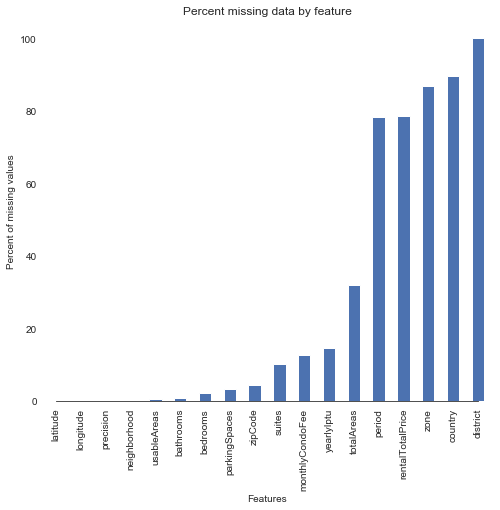

In [19]:
# Setup do plot
sns.set_style("white")
f, ax = plt.subplots(figsize=(8, 7))
sns.set_color_codes(palette='deep')

# Identificando os valores missing
missing = round(train.isnull().mean()*100,2)
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar(color="b")

# Visual presentation
ax.xaxis.grid(False)
ax.set(ylabel="Percent of missing values")
ax.set(xlabel="Features")
ax.set(title="Percent missing data by feature")
sns.despine(trim=True, left=True)

In [20]:
# Funcao para tratar os dados missing de cada variavel
def fill_na(data):
    data['rentalTotalPrice'].fillna(0,inplace=True)
    data['monthlyCondoFee'].fillna(0,inplace=True)
    data['period'].fillna('NONE',inplace=True)
    data['yearlyIptu'].fillna(0,inplace=True)
    data['country'].fillna('BR',inplace=True)
    data['district'].fillna('None',inplace=True)
    data['zone'].fillna('None',inplace=True)
    data['zipCode'].fillna('None',inplace=True)
    data['state'].fillna('SP',inplace=True)
    data['neighborhood'].fillna('None',inplace=True)
    #data['bairro'].fillna('None',inplace=True)
    data['suites'].fillna(0,inplace=True)
    data['parkingSpaces'].fillna(data['parkingSpaces'].mode()[0],inplace=True)
    data['bedrooms'].fillna(data['bedrooms'].mode()[0],inplace=True)
    data['bathrooms'].fillna(data['bathrooms'].mode()[0],inplace=True)
    data['totalAreas'].fillna(data['totalAreas'].mode()[0],inplace=True)
    data['usableAreas'].fillna(data['usableAreas'].mode()[0],inplace=True)
    data['latitude'].fillna(0,inplace=True)
    data['longitude'].fillna(0,inplace=True)
    data['precision'].fillna('NO_GEOCODE',inplace=True)    

In [21]:
# Chamando a funcao para tratamento dos dados missing no dataset de treino
fill_na(train)
fill_na(test)

In [22]:
# Convertendo algumas variaveis  para inteiro
# Dataset de treino
train['bathrooms'] = train['bathrooms'].astype(int)
train['bedrooms'] = train['bedrooms'].astype(int)
train['parkingSpaces'] = train['parkingSpaces'].astype(int)
train['suites'] = train['suites'].astype(int)

# Dataset de teste
test['bathrooms'] = test['bathrooms'].astype(int)
test['bedrooms'] = test['bedrooms'].astype(int)
test['parkingSpaces'] = test['parkingSpaces'].astype(int)
test['suites'] = test['suites'].astype(int)

In [23]:
# Fazendo uma limpeza na memoria
gc.collect()

91

In [24]:
# Verificando as 5 primeiras linhas do nosso dataset de treino
train.head(5)

,city,country,district,latitude,longitude,precision,neighborhood,state,zipCode,zone,bathrooms,bedrooms,listingStatus,owner,parkingSpaces,businessType,monthlyCondoFee,period,price,rentalTotalPrice,yearlyIptu,publicationType,suites,totalAreas,unitTypes,usableAreas,createdAt_day,createdAt_month,createdAt_year,createdAt_weekofyear,createdAt_weekday,createdAt_weekend
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
787c7bd19d,São Paulo,BR,None,-23.612923,-46.614222,ROOFTOP,Jardim da Saúde,São Paulo,04290030,Zona Sul,3,4,ACTIVE,False,6,SALE,0.0,NONE,700000,0.0,0.0,STANDARD,1,388.0,TWO_STORY_HOUSE,388.0,7,2,2017,6,1,0
4d68c0cdbe,São Paulo,BR,None,-23.643962,-46.593475,RANGE_INTERPOLATED,Vila Santa Teresa (Zona Sul),São Paulo,04187320,Zona Sul,2,3,ACTIVE,False,2,SALE,0.0,NONE,336000,0.0,0.0,STANDARD,1,129.0,HOME,129.0,21,3,2016,12,0,0
e7e0b554ac,São Paulo,BR,None,-23.568559,-46.647452,ROOFTOP,Bela Vista,São Paulo,01311000,None,4,0,ACTIVE,False,5,RENTAL,4900.0,MONTHLY,24929,29829.0,4040.0,STANDARD,0,0.0,COMMERCIAL_PROPERTY,396.0,18,12,2018,51,1,0
6654d93423,São Paulo,BR,None,-23.598023,-46.682781,RANGE_INTERPOLATED,Vila Olímpia,São Paulo,04550004,None,2,3,ACTIVE,False,2,SALE,686.0,NONE,739643,0.0,1610.0,STANDARD,1,80.0,APARTMENT,80.0,26,10,2018,43,4,0
9ffaf676ae,São Paulo,BR,None,-23.582497,-46.653027,RANGE_INTERPOLATED,Paraíso,São Paulo,04005030,None,5,4,ACTIVE,False,5,SALE,6230.0,NONE,7520099,0.0,18900.0,STANDARD,4,332.0,APARTMENT,3322.0,14,12,2018,50,4,0


In [25]:
# Verificando as 5 primeiras linhas do nosso dataset de test
test.head(5)

,city,country,district,latitude,longitude,precision,neighborhood,state,zipCode,zone,bathrooms,bedrooms,listingStatus,owner,parkingSpaces,businessType,monthlyCondoFee,period,rentalTotalPrice,yearlyIptu,publicationType,suites,totalAreas,unitTypes,usableAreas,createdAt_day,createdAt_month,createdAt_year,createdAt_weekofyear,createdAt_weekday,createdAt_weekend
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
89224365f8,São Paulo,BR,None,-23.557225,-46.662765,GEOMETRIC_CENTER,Consolação,São Paulo,01415000,Centro,1,1,ACTIVE,False,1,SALE,0.0,NONE,0.0,0.0,STANDARD,0,47.0,APARTMENT,47.0,20,10,2015,43,1,0
363731333f,São Paulo,BR,None,-23.592852,-46.581879,ROOFTOP,Quinta da Paineira,São Paulo,03152155,Zona Leste,0,2,ACTIVE,False,1,SALE,0.0,NONE,0.0,0.0,STANDARD,0,55.0,APARTMENT,55.0,31,7,2018,31,1,0
6e6283378a,São Paulo,BR,None,-23.493609,-46.638456,ROOFTOP,Chora Menino,São Paulo,02461000,None,3,3,ACTIVE,False,2,SALE,686.0,NONE,0.0,0.0,STANDARD,1,0.0,APARTMENT,92.0,25,1,2018,4,3,0
4c29a27f44,São Paulo,BR,None,-23.607981,-46.686180,GEOMETRIC_CENTER,Brooklin Paulista,São Paulo,04561003,None,4,3,ACTIVE,False,3,SALE,770.0,NONE,0.0,368.0,STANDARD,3,145.0,APARTMENT,145.0,27,4,2018,17,4,0
7b16cf224b,São Paulo,BR,None,-23.540604,-46.715088,ROOFTOP,Alto de Pinheiros,São Paulo,05468140,None,2,2,ACTIVE,False,1,SALE,472.0,NONE,0.0,79.0,STANDARD,1,76.0,APARTMENT,76.0,16,9,2018,37,6,1


## Verificando cada uma das variaveis e sua distribuição no dataset

### Iniciando com a análise da variavel target 'PRICE'

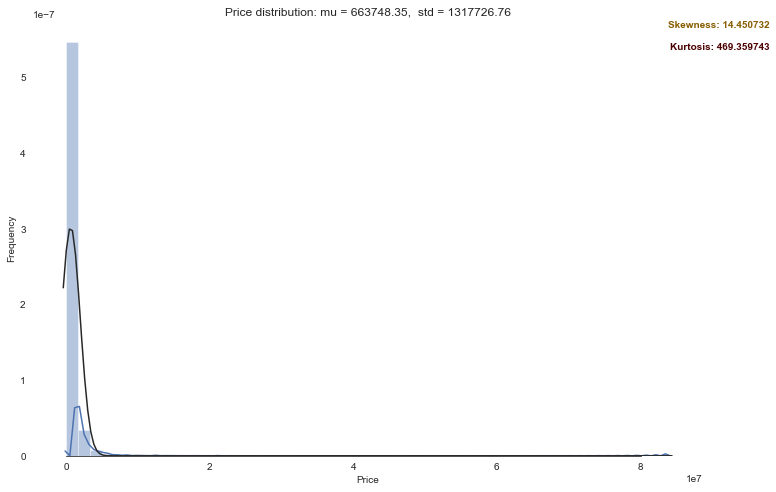

In [26]:
# Visualizando informações de distribuicao da variavel price
sns.set_style("white")
sns.set_color_codes(palette='deep')
f, ax = plt.subplots(figsize=(12, 8))

# Fit a normal distribution
mu, std = norm.fit(train["price"])

# Verificando a distribuicao de frequencia da variavel PRICE
sns.distplot(train["price"], color="b", fit = stats.norm)
ax.xaxis.grid(False)
ax.set(ylabel="Frequency")
ax.set(xlabel="Price")
ax.set(title="Price distribution: mu = %.2f,  std = %.2f" % (mu, std))
sns.despine(trim=True, left=True)

# Adicionando Skewness e Kurtosis
ax.text(x=1.1, y=1, transform=ax.transAxes, s="Skewness: %f" % train["price"].skew(),\
        fontweight='demibold', fontsize=10, verticalalignment='top', horizontalalignment='right',\
        backgroundcolor='white', color='xkcd:poo brown')
ax.text(x=1.1, y=0.95, transform=ax.transAxes, s="Kurtosis: %f" % train["price"].kurt(),\
        fontweight='demibold', fontsize=10, verticalalignment='top', horizontalalignment='right',\
        backgroundcolor='white', color='xkcd:dried blood')

plt.show()

In [27]:
# Realizando uma transformacao logaritma na variavel price
# Isso irá melhorar algumas analises abaixo
train["price_log"] = np.log1p(train["price"])

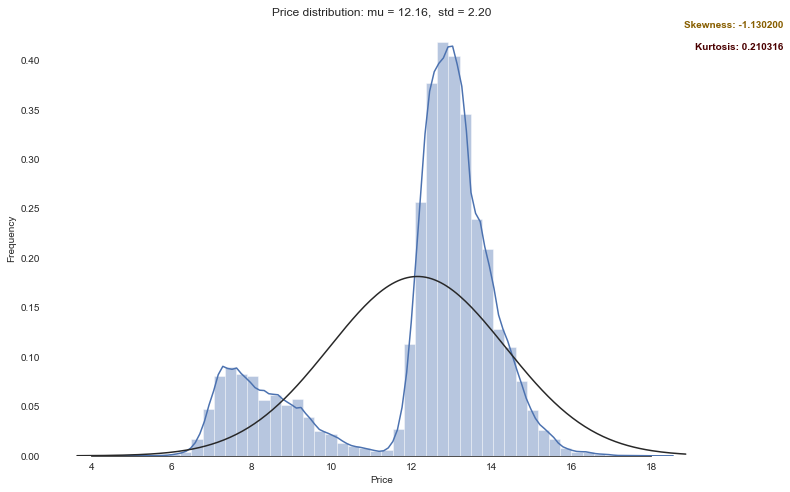

In [28]:
# Visualizando informações de distribuicao da variavel price
sns.set_style("white")
sns.set_color_codes(palette='deep')
f, ax = plt.subplots(figsize=(12, 8))

# Fit a normal distribution
mu, std = norm.fit(train["price_log"])

# Verificando a distribuicao de frequencia da variavel PRICE
sns.distplot(train["price_log"], color="b", fit = stats.norm)
ax.xaxis.grid(False)
ax.set(ylabel="Frequency")
ax.set(xlabel="Price")
ax.set(title="Price distribution: mu = %.2f,  std = %.2f" % (mu, std))
sns.despine(trim=True, left=True)

# Adicionando Skewness e Kurtosis
ax.text(x=1.1, y=1, transform=ax.transAxes, s="Skewness: %f" % train["price_log"].skew(),\
        fontweight='demibold', fontsize=10, verticalalignment='top', horizontalalignment='right',\
        backgroundcolor='white', color='xkcd:poo brown')
ax.text(x=1.1, y=0.95, transform=ax.transAxes, s="Kurtosis: %f" % train["price_log"].kurt(),\
        fontweight='demibold', fontsize=10, verticalalignment='top', horizontalalignment='right',\
        backgroundcolor='white', color='xkcd:dried blood')

plt.show()

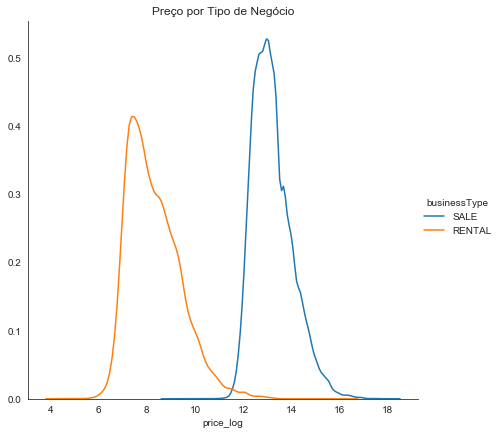

In [29]:
# Com esse grafico de densidade percebe-se que se tipo de negocio for SALE (venda)
# o preco do imovel é superior a preco do imovel para RENTAL (aluguel)
sns.FacetGrid(train, hue="businessType", height=6) \
   .map(sns.kdeplot, "price_log") \
   .add_legend()
plt.title('Preço por Tipo de Negócio');

In [30]:
# Analise Exploratoria da variavel 'businessType'
# Esta é a variavel que irei utilizar para separar o dataset para obter somente os imoveis de VENDA
# Estou considerando o objetivo do desafio, que é prever o preco de VENDA dos imoveis
train.groupby('businessType').size()

businessType
RENTAL     28632
SALE      105332
dtype: int64

Text(0.5, 1.0, 'Distribuição por Tipos de Imóveis')

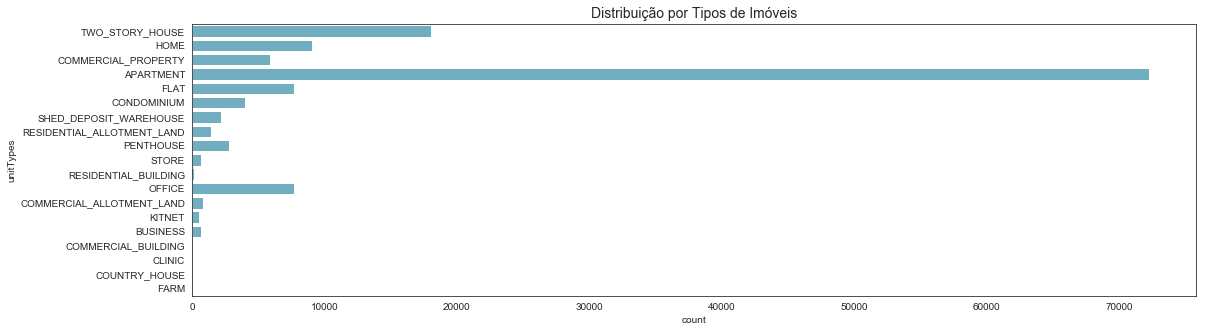

In [31]:
# Analise Exploratoria da variavel 'unitTypes'
# É possivel visualizar claramente que a quantidade 
# de apartamentos a venda é bem superior aos demais tipos de imóveis
f, ax = plt.subplots(figsize=(18, 5))
sns.countplot(y='unitTypes', data=train, color='c')
ax.set_title('Distribuição por Tipos de Imóveis', fontsize=14)

### Observação Importante
De acordo com a informação da distribuição da variavel target (price) e o grafico de densidade de preco por tipo de negocio (venda ou aluguel), vou dividir o dataset considerando o objetivo do desafio e realizando uma analise mais aprofundada.

Considerando o objetivo deste projeto em estimar o preço de venda de apartamentos, vou dividir o dataset considerando esta regra e realizar uma analise mais aprofundada das outras variaveis após essa divisão nos dados.

- SALE (imoveis para venda)
- APARTMENT(apartamentos)

In [32]:
# Criando o dataset de imoveis para venda, conforme objetivo do desafio
train_sale = (train[(train['businessType'] == 'SALE') & (train['unitTypes'] == 'APARTMENT')])

In [33]:
train_sale.groupby('businessType').size()

businessType
SALE    64146
dtype: int64

In [34]:
train_sale.groupby('unitTypes').size()

unitTypes
APARTMENT    64146
dtype: int64

In [35]:
# Verificando a quantidade de registros e coluna para o novo dataset
# Exatamente a mesma quantidade dos registros de SALE e APARTMENT
train_sale.shape

(64146, 33)

### Análise das demais variaveis do dataset

In [36]:
# Analise Exploratoria da variavel 'acountry'
train_sale.groupby('country').size()

country
BR    64146
dtype: int64

In [37]:
# Analise Exploratoria da variavel 'state'
train_sale.groupby('state').size()

state
SP                  203
Santa Catarina        1
São Paulo         63942
dtype: int64

In [38]:
# Analise Exploratoria da variavel 'city'
train_sale.groupby('city').size()

city
São Paulo    64146
dtype: int64

In [39]:
# Analise Exploratoria da variavel 'district'
train_sale.groupby('district').size()

district
Jaraguá        3
None       64143
dtype: int64

In [40]:
# Analise Exploratoria da variavel 'zone'
train_sale.groupby('zone').size()

zone
Centro         1564
None          56488
Zona Leste     1185
Zona Norte     1336
Zona Oeste     1039
Zona Sul       2534
dtype: int64

In [41]:
# Analise Exploratoria da variavel 'neighborhood'
train_sale.groupby('neighborhood').size()

neighborhood
176                                                  3
204                                                  4
A. Pinheiros                                         4
Aclimação                                          391
Aeroporto                                            2
Alto Klabin                                         10
Alto Mandaqui                                        1
Alto da Boa Vista                                   13
Alto da Lapa                                       176
Alto da Mooca                                      285
Alto de Pinheiros                                  240
Alto do Pari                                         7
Altos de Vila Prudente                               2
Aricanduva                                           9
Artur Alvim                                         35
BROOKLIN                                             2
Balneário São Francisco                              1
Barra Funda                                        1

In [42]:
# Analise Exploratoria da variavel 'precision'
train_sale.groupby('precision').size()

precision
APPROXIMATE            2945
GEOMETRIC_CENTER      18477
NO_GEOCODE               21
RANGE_INTERPOLATED     6043
ROOFTOP               36660
dtype: int64

In [43]:
# Analise Exploratoria da variavel 'listingStatus'
train_sale.groupby('listingStatus').size()

listingStatus
ACTIVE    64146
dtype: int64

In [44]:
# Analise Exploratoria da variavel 'owner'
train_sale.groupby('owner').size()

owner
False    64129
True        17
dtype: int64

In [45]:
# Analise Exploratoria da variavel 'period'
train_sale.groupby('period').size()

period
MONTHLY      338
NONE       63808
dtype: int64

In [46]:
# Analise Exploratoria da variavel 'publicationType'
train_sale.groupby('publicationType').size()

publicationType
PREMIUM      1019
STANDARD    63127
dtype: int64

In [47]:
# Analise Exploratoria da variavel 'publicationType'
test.groupby('publicationType').size()

publicationType
PREMIUM       269
STANDARD    15767
dtype: int64

Text(0.5, 1.0, 'Distribuição por qtde de Banheiros')

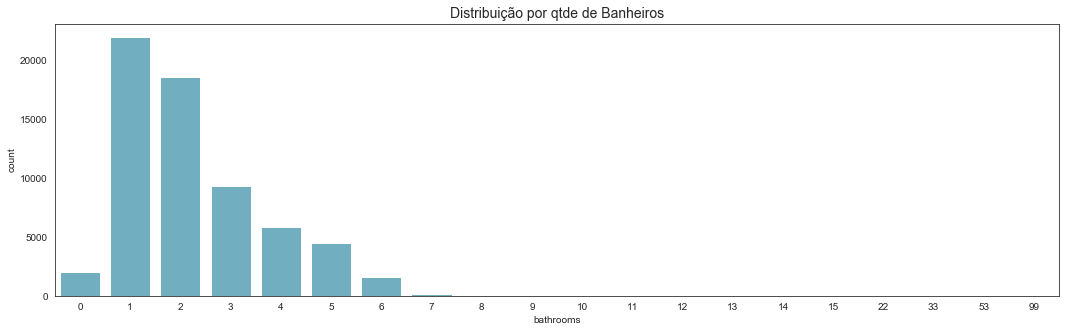

In [48]:
# Analise Exploratoria da variavel 'bathrooms'
f, ax = plt.subplots(figsize=(18, 5))
sns.countplot(x='bathrooms', data=train_sale, color='c')
ax.set_title('Distribuição por qtde de Banheiros', fontsize=14)

Text(0.5, 1.0, 'Distribuição por qtde de Quartos')

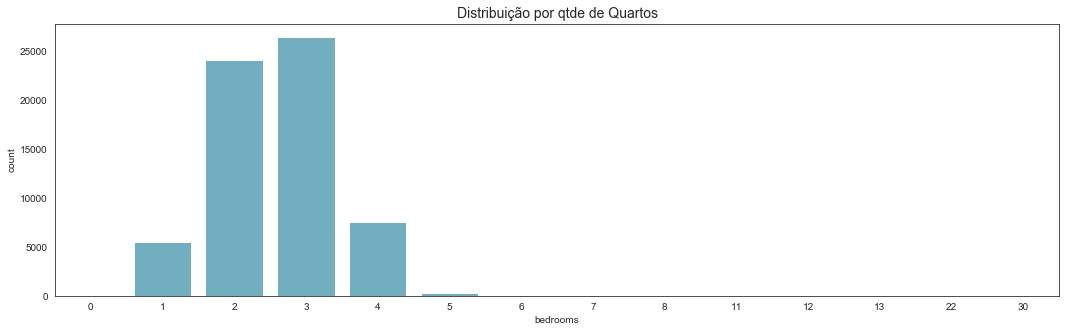

In [49]:
# Analise Exploratoria da variavel 'bedrooms'
f, ax = plt.subplots(figsize=(18, 5))
sns.countplot(x='bedrooms', data=train_sale, color='c')
ax.set_title('Distribuição por qtde de Quartos', fontsize=14)

Text(0.5, 1.0, 'Distribuição por qtde de Suites')

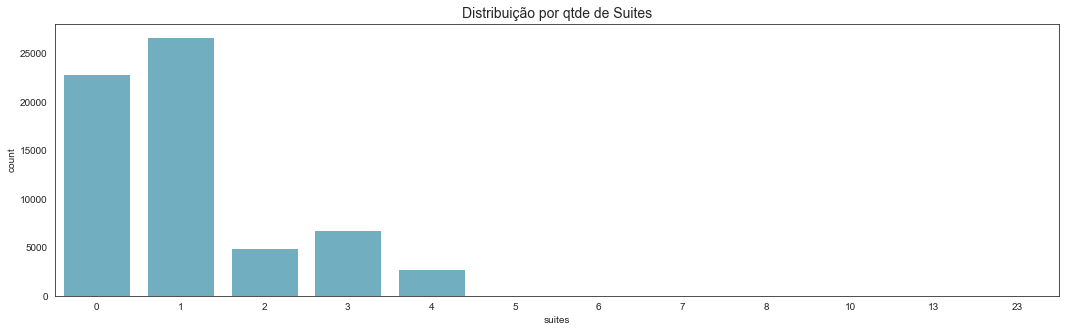

In [50]:
# Analise Exploratoria da variavel 'bedrooms'
f, ax = plt.subplots(figsize=(18, 5))
sns.countplot(x='suites', data=train_sale, color='c')
ax.set_title('Distribuição por qtde de Suites', fontsize=14)

Text(0.5, 1.0, 'Distribuição por Espaço de Garagem')

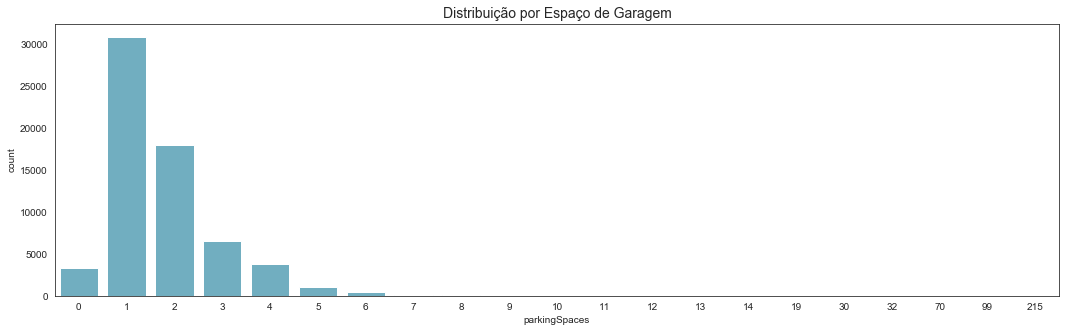

In [51]:
# Analise Exploratoria da variavel 'parkingSpaces'
f, ax = plt.subplots(figsize=(18, 5))
sns.countplot(x='parkingSpaces', data=train_sale, color='c')
ax.set_title('Distribuição por Espaço de Garagem', fontsize=14)

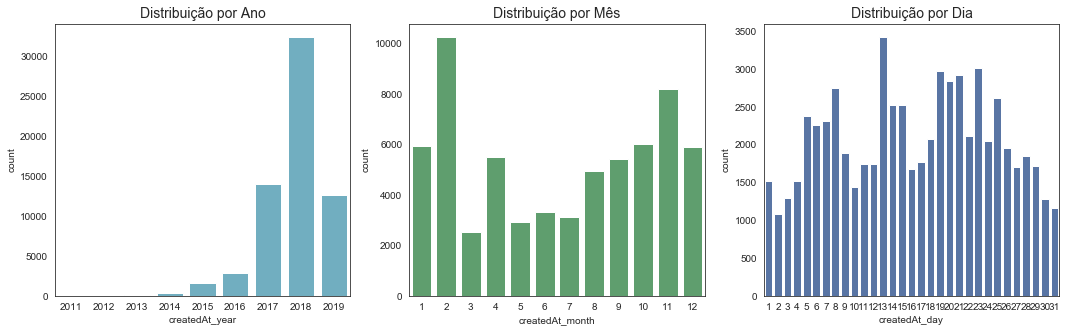

In [52]:
# Analise Exploratoria das variavel criadas a partir da coluna 'createdAt'
f, ax = plt.subplots(1,3, figsize=(18, 5))

# Aqui é possível observar que os anos de 2017, 2018 e 2019 tem um volume maior de registros,
# sendo que o ano de 2018 se destaca
sns.countplot(train_sale['createdAt_year'], color='c', ax=ax[0])
ax[0].set_title('Distribuição por Ano', fontsize=14)

# Aqui é possível observar uma quantidade maior de imóveis cadastrados a partir do segundo semestre, 
# no entanto, um destaque para o mes de fevereiro
sns.countplot(train_sale['createdAt_month'], color='g', ax=ax[1])
ax[1].set_title('Distribuição por Mês', fontsize=14)

sns.countplot(train_sale['createdAt_day'], color='b', ax=ax[2])
ax[2].set_title('Distribuição por Dia', fontsize=14)

f.show()

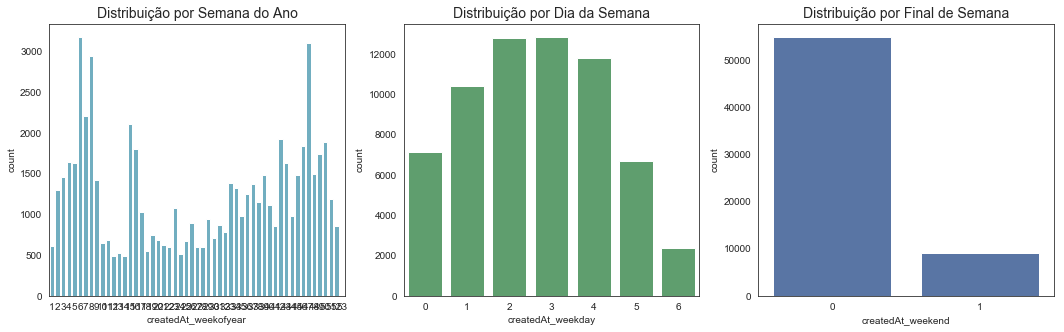

In [53]:
# Analise Exploratoria das variavel criadas a partir da coluna 'createdAt'
f, ax = plt.subplots(1,3, figsize=(18, 5))

# É possível verificar alguns picos no inicio do ano e no final do ano
sns.countplot(train_sale['createdAt_weekofyear'], color='c', ax=ax[0])
ax[0].set_title('Distribuição por Semana do Ano', fontsize=14)

# É possível verificar uma alta taxa de cadastro de imoveis no meio da semana (terca, quarta e quinta)
sns.countplot(train_sale['createdAt_weekday'], color='g', ax=ax[1])
ax[1].set_title('Distribuição por Dia da Semana', fontsize=14)

# Muitos registros foram criados durante a semana
sns.countplot(train_sale['createdAt_weekend'], color='b', ax=ax[2])
ax[2].set_title('Distribuição por Final de Semana', fontsize=14)

f.show()

### Relacionamento do preço de venda dos imóveis com outras features

In [54]:
# Verificar os bairros com preco de venda acima de 10.000.000
q1 = """SELECT neighborhood, round(max(price),2) 
          FROM train_sale
         GROUP BY neighborhood 
         HAVING max(price) >= 5000000"""
print(ps.sqldf(q1, locals()))

                     neighborhood  round(max(price),2)
0               Alto de Pinheiros            8400000.0
1                      Bela Vista            6860000.0
2                         Boaçava            5110000.0
3                      Campo Belo            5362000.0
4                 Cerqueira César           17500000.0
5                   Chácara Itaim            9100000.0
6                   Cidade Jardim           15399999.0
7                      Consolação            5880000.0
8                    Higienópolis           14000000.0
9                      Ibirapuera            7648619.0
10                   Indianópolis            7821497.0
11                     Itaim Bibi           18072262.0
12                 Jardim America            6790000.0
13                 Jardim América            6930000.0
14           Jardim Analia Franco            5250000.0
15           Jardim Anália Franco            5250000.0
16                  Jardim Europa           19950000.0
17        

In [55]:
# Verificar os bairros com preco de venda acima de 5.000.000 com quantidade de registros igual a 1
# Estes registros 'podem' ser caracterizados como problemas nos dados
q1 = """SELECT neighborhood, count()
          FROM train_sale
         WHERE price >= 5000000
        GROUP BY neighborhood
        HAVING COUNT() = 1"""
print(ps.sqldf(q1, locals()))

             neighborhood  count()
0              Bela Vista        1
1                 Boaçava        1
2              Campo Belo        1
3    Jardim Analia Franco        1
4  Jardim Nova Vitória II        1
5               Jd Europa        1
6                Pacaembu        1
7                Perdizes        1
8       Vila Buenos Aires        1


In [56]:
# Criando uma classe para trabalhar com gráfico de mapa usando o pacote folium
def map_points(df, lat_col='latitude', lon_col='longitude', zoom_start=11, \
                plot_points=False, pt_radius=15, \
                draw_heatmap=False, heat_map_weights_col=None, \
                heat_map_weights_normalize=True, heat_map_radius=15):

    ## center map in the middle of points center in
    middle_lat = df[lat_col].median()
    middle_lon = df[lon_col].median()

    curr_map = folium.Map(location=[middle_lat, middle_lon],
                          zoom_start=zoom_start)

    # add points to map
    if plot_points:
        for _, row in df.iterrows():
            folium.CircleMarker([row[lat_col], row[lon_col]],
                                radius=pt_radius,
                                popup=row['name'],
                                fill_color="#3db7e4",
                               ).add_to(curr_map)

    # add heatmap
    if draw_heatmap:
        if heat_map_weights_col is None:
            cols_to_pull = [lat_col, lon_col]
        else:
            if heat_map_weights_normalize:
                df[heat_map_weights_col] = \
                    df[heat_map_weights_col] / df[heat_map_weights_col].sum()

            cols_to_pull = [lat_col, lon_col, heat_map_weights_col]

        stations = df[cols_to_pull].as_matrix()
        curr_map.add_children(plugins.HeatMap(stations, radius=heat_map_radius))

    return curr_map

In [57]:
# Analisando a media de preco por bairro (considerando imoveis para venda)
# É possível verificar que a média de preço de venda está bem distribuída entre todos os bairros de São Paulo
dfMediaPorBairroVenda = np.floor(train_sale.groupby('neighborhood')['price_log'].agg('mean'))
dfMediaPorBairroVenda.name = 'price_log'

# Criando um dataset temporario com o agrupamento da media para plotar no mapa
tmp = pd.merge(left=train_sale[['neighborhood','latitude','longitude']],
               right=dfMediaPorBairroVenda.to_frame(),
               how='outer',
               left_on='neighborhood',
               right_index=True)
tmp = tmp.rename(columns={"neighborhood": "name"})
tmp['price_log'] = tmp['price_log'].fillna(value=0)

# Removendo valores duplicados
tmp.drop_duplicates(keep=False,inplace=True) 

# Plot do mapa de calor por preco x bairro
map_points(tmp, 
           plot_points=False, 
           draw_heatmap=True, 
           heat_map_weights_normalize=False,
           heat_map_weights_col='price_log',
           heat_map_radius=9)

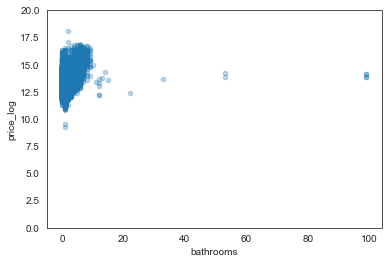

In [58]:
# Relacao do preco do imovel com a quantidade de banheiros
# Percebe-se que existem alguns outliers (ex. de quantidade de banheiros acima de 200)
data = pd.concat([train_sale['price_log'], train_sale['bathrooms']], axis=1)
data.plot.scatter(x='bathrooms', y='price_log', alpha=0.3, ylim=(0,20));

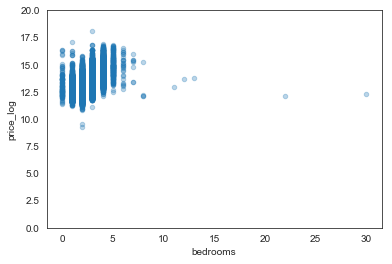

In [59]:
# Relacao do preco do imovel com a quantidade de quartos
# Percebe-se que existem alguns outliers (ex. de quantidade de quartos acima de 600)
data = pd.concat([train_sale['price_log'], train_sale['bedrooms']], axis=1)
data.plot.scatter(x='bedrooms', y='price_log', alpha=0.3, ylim=(0,20));

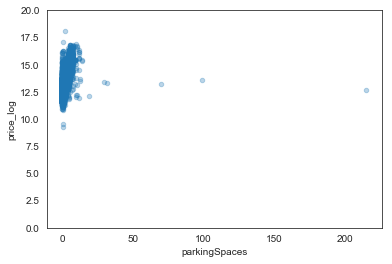

In [60]:
# Relacao do preco do imovel com a quantidade de vagas de garagem
# Percebe-se que existem alguns outliers (ex. de quantidade de vagas de garagem acima de 200)
data = pd.concat([train_sale['price_log'], train_sale['parkingSpaces']], axis=1)
data.plot.scatter(x='parkingSpaces', y='price_log', alpha=0.3, ylim=(0,20));

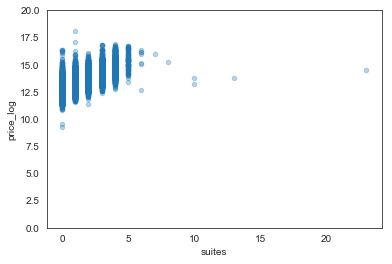

In [61]:
# Relacao do preco do imovel com a quantidade de vagas de garagem
# Percebe-se que existem alguns outliers (ex. de quantidade de vagas de garagem acima de 200)
data = pd.concat([train_sale['price_log'], train_sale['suites']], axis=1)
data.plot.scatter(x='suites', y='price_log', alpha=0.3, ylim=(0,20));

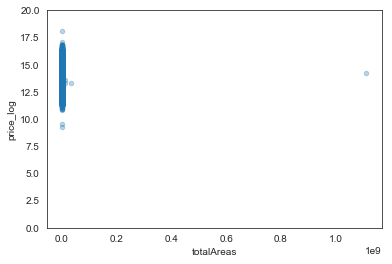

In [62]:
# Relacao do preco do imovel com o total da area
# Percebe-se que existem alguns outliers
data = pd.concat([train_sale['price_log'], train_sale['totalAreas']], axis=1)
data.plot.scatter(x='totalAreas', y='price_log', alpha=0.3, ylim=(0,20));

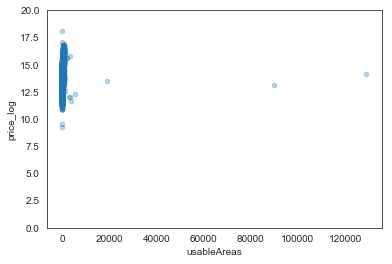

In [63]:
# Relacao do preco do imovel com o total da area util
# Percebe-se que existem alguns outliers
data = pd.concat([train_sale['price_log'], train_sale['usableAreas']], axis=1)
data.plot.scatter(x='usableAreas', y='price_log', alpha=0.3, ylim=(0,20));

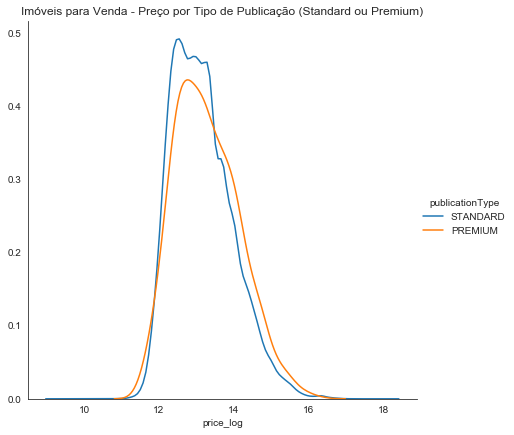

In [64]:
# Com esse grafico de densidade percebe-se que se os precos para o tipo
# Standard e Premium são bem parecidos
sns.FacetGrid(train_sale, hue="publicationType", height=6) \
   .map(sns.kdeplot, "price_log") \
   .add_legend()
plt.title('Imóveis para Venda - Preço por Tipo de Publicação (Standard ou Premium)');

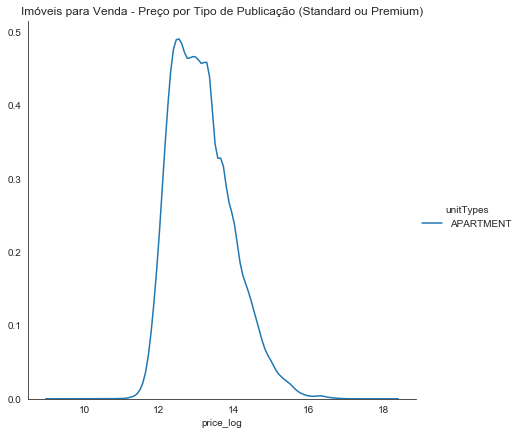

In [65]:
# Com esse grafico de densidade percebe-se que se os precos estão bem lineares por tipo de unidade
sns.FacetGrid(train_sale, hue="unitTypes", height=6) \
   .map(sns.kdeplot, "price_log") \
   .add_legend()
plt.title('Imóveis para Venda - Preço por Tipo de Publicação (Standard ou Premium)');

# Feature Engineering

In [66]:
# Fazendo uma limpeza na memoria
gc.collect()

18764

In [67]:
# Removendo algumas colunas do dataset que identifiquei como não necessárias para o modelo
# Dataset de treino
train_sale.drop(columns = ["city",
                           "country",
                           "listingStatus",
                           "businessType",
                           "rentalTotalPrice",
                           "period",
                           "price_log",
                           "unitTypes"
                          ], inplace = True) 

# Dataset de Teste
test.drop(columns = ["city",
                     "country",
                     "listingStatus",
                     "businessType",
                     "rentalTotalPrice",
                     "period",
                     "unitTypes"
                    ], inplace = True) 

### Encoding Categorical Variables

Label encoding: atribua cada categoria exclusiva em uma variável categórica com um inteiro. Nenhuma nova coluna é criada.

In [68]:
# Cria um label encoder object
le = preprocessing.LabelEncoder()
suf="_le"

# Iteracao para cada coluna do dataset de treino
for col in train_sale:
    if train_sale[col].dtype == 'object':
        le.fit_transform(train_sale[col].astype(str))
        train_sale[col+suf] = le.transform(train_sale[col])      

In [69]:
# Iteracao para cada coluna do dataset de teste
for col in test:
    if test[col].dtype == 'object':
        le.fit_transform(test[col].astype(str))
        test[col+suf] = le.transform(test[col])  

### Criando algumas novas colunas

Os modelos de Machine Learning têm dificuldade em reconhecer padrões mais complexos. Então vou criar alguns recursos baseados em minha intuição sobre o conjunto de dados.

In [70]:
# Dataset de Treino
# Nova coluna para identificar se o imóvel tem estacionamento
train_sale['hasparkingSpaces'] = train_sale['parkingSpaces'].apply(lambda x: 1 if x > 0 else 0)

# Nova coluna para identificar se o imóvel tem pelo menos um (1) banheiro
train_sale['hasbathrooms'] = train_sale['bathrooms'].apply(lambda x: 1 if x > 0 else 0)

# Nova coluna para identificar se o imóvel tem pelo menos um (1) quarto
train_sale['hasbedrooms'] = train_sale['bedrooms'].apply(lambda x: 1 if x > 0 else 0)

# Nova coluna para identificar se o imóvel tem pelo menos uma (1) suíte
train_sale['hassuites'] = train_sale['suites'].apply(lambda x: 1 if x > 0 else 0)

# Nova coluna que identifica a soma das taxas obrigatórias como taxa do condominio e IPTU
train_sale['totalFee'] = train_sale['monthlyCondoFee'] * train_sale['yearlyIptu']

In [71]:
# Dataset de Teste
# Nova coluna para identificar se o imóvel tem estacionamento
test['hasparkingSpaces'] = test['parkingSpaces'].apply(lambda x: 1 if x > 0 else 0)

# Nova coluna para identificar se o imóvel tem pelo menos um (1) banheiro
test['hasbathrooms'] = test['bathrooms'].apply(lambda x: 1 if x > 0 else 0)

# Nova coluna para identificar se o imóvel tem pelo menos um (1) quarto
test['hasbedrooms'] = test['bedrooms'].apply(lambda x: 1 if x > 0 else 0)

# Nova coluna para identificar se o imóvel tem pelo menos uma (1) suíte
test['hassuites'] = test['suites'].apply(lambda x: 1 if x > 0 else 0)

# Nova coluna que identifica a soma das taxas obrigatórias como taxa do condominio e IPTU
test['totalFee'] = test['monthlyCondoFee'] * test['yearlyIptu']

In [72]:
# Analisando o dataset após aplicar feature enginnering
train_sale.head()

,district,latitude,longitude,precision,neighborhood,state,zipCode,zone,bathrooms,bedrooms,owner,parkingSpaces,monthlyCondoFee,price,yearlyIptu,publicationType,suites,totalAreas,usableAreas,createdAt_day,createdAt_month,createdAt_year,createdAt_weekofyear,createdAt_weekday,createdAt_weekend,district_le,precision_le,neighborhood_le,state_le,zipCode_le,zone_le,publicationType_le,hasparkingSpaces,hasbathrooms,hasbedrooms,hassuites,totalFee
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
6654d93423,None,-23.598023,-46.682781,RANGE_INTERPOLATED,Vila Olímpia,São Paulo,04550004,None,2,3,False,2,686.0,739643,1610.0,STANDARD,1,80.0,80.0,26,10,2018,43,4,0,1,3,986,2,4629,1,1,1,1,1,1,1104460.0
9ffaf676ae,None,-23.582497,-46.653027,RANGE_INTERPOLATED,Paraíso,São Paulo,04005030,None,5,4,False,5,6230.0,7520099,18900.0,STANDARD,4,332.0,3322.0,14,12,2018,50,4,0,1,3,595,2,3162,1,1,1,1,1,1,117747000.0
f03e22422a,None,-23.561318,-46.686355,ROOFTOP,Pinheiros,São Paulo,05415040,None,1,3,False,2,1120.0,630700,489.0,STANDARD,0,0.0,94.0,29,5,2018,22,1,0,1,4,672,2,5801,1,1,1,1,1,0,547680.0
8e1922c386,None,-23.568103,-46.628405,RANGE_INTERPOLATED,Aclimação,São Paulo,01530010,None,4,4,False,2,0.0,1106000,0.0,PREMIUM,3,141.0,141.0,9,1,2019,2,2,0,1,3,3,2,794,1,0,1,1,1,1,0.0
690407f653,None,-23.634531,-46.732089,ROOFTOP,Vila Andrade,São Paulo,05717170,Zona Sul,0,4,False,3,1400.0,910000,6300.0,STANDARD,4,188.0,188.0,29,9,2018,39,5,1,1,4,757,2,6344,5,1,1,0,1,1,8820000.0


In [73]:
# Analisando o dataset após aplicar feature enginnering
test.head()

,district,latitude,longitude,precision,neighborhood,state,zipCode,zone,bathrooms,bedrooms,owner,parkingSpaces,monthlyCondoFee,yearlyIptu,publicationType,suites,totalAreas,usableAreas,createdAt_day,createdAt_month,createdAt_year,createdAt_weekofyear,createdAt_weekday,createdAt_weekend,district_le,precision_le,neighborhood_le,state_le,zipCode_le,zone_le,publicationType_le,hasparkingSpaces,hasbathrooms,hasbedrooms,hassuites,totalFee
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
89224365f8,None,-23.557225,-46.662765,GEOMETRIC_CENTER,Consolação,São Paulo,01415000,Centro,1,1,False,1,0.0,0.0,STANDARD,0,47.0,47.0,20,10,2015,43,1,0,0,1,115,1,365,0,1,1,1,1,0,0.0
363731333f,None,-23.592852,-46.581879,ROOFTOP,Quinta da Paineira,São Paulo,03152155,Zona Leste,0,2,False,1,0.0,0.0,STANDARD,0,55.0,55.0,31,7,2018,31,1,0,0,4,477,1,1469,2,1,1,0,1,0,0.0
6e6283378a,None,-23.493609,-46.638456,ROOFTOP,Chora Menino,São Paulo,02461000,None,3,3,False,2,686.0,0.0,STANDARD,1,0.0,92.0,25,1,2018,4,3,0,0,4,60,1,1037,1,1,1,1,1,1,0.0
4c29a27f44,None,-23.607981,-46.686180,GEOMETRIC_CENTER,Brooklin Paulista,São Paulo,04561003,None,4,3,False,3,770.0,368.0,STANDARD,3,145.0,145.0,27,4,2018,17,4,0,0,1,27,1,2974,1,1,1,1,1,1,283360.0
7b16cf224b,None,-23.540604,-46.715088,ROOFTOP,Alto de Pinheiros,São Paulo,05468140,None,2,2,False,1,472.0,79.0,STANDARD,1,76.0,76.0,16,9,2018,37,6,1,0,4,9,1,3753,1,1,1,1,1,1,37288.0


### Feature transformations

Vou criar mais colunas calculando as transformações de log e quadrado de algumas features numéricas. Vou fazer isso manualmente, porque alguns modelos de Machine Learning não dizem com segurança se log (feature) ou feature^2 é um preditor do Preco.

In [74]:
# Realizando uma transformacao logaritma na variavel price
# Isso irá melhorar a acuracia do modelo de machine learning
train_sale["price"] = np.log1p(train_sale["price"])

In [75]:
# Procedimento para criar novas colunas aplicando função logarítma nos campos numéricos escolhidos
def logs(res, ls):
    m = res.shape[1]
    for l in ls:
        res = res.assign(newcol=pd.Series(np.log(1.01+res[l])).values)   
        res.columns.values[m] = l + '_log'
        m += 1
    return res

log_features = ['monthlyCondoFee',
                'yearlyIptu',
                'totalAreas',
                'usableAreas',
                'totalFee']

In [76]:
# Procedimento para criar novas colunas aplicando função quadrática nos campos numéricos escolhidos
def squares(res, ls):
    m = res.shape[1]
    for l in ls:
        res = res.assign(newcol=pd.Series(res[l]*res[l]).values)   
        res.columns.values[m] = l + '_sq'
        m += 1
    return res 

squared_features = ['monthlyCondoFee_log', 
                    'yearlyIptu_log',
                    'totalAreas_log', 
                    'usableAreas_log', 
                    'totalFee_log']

In [77]:
# Aplicando no dataset de treino
train_sale = logs(train_sale, log_features)
train_sale = squares(train_sale, squared_features)

In [78]:
# Aplicando no dataset de teste
test = logs(test, log_features)
test = squares(test, squared_features)

In [79]:
# Com a criação das novas colunas, alguns valores inf e nan também foram criados, sendo necessário este tratamento
# Neste caso, estou aplicando o valor 0 (zero) para eles
# Dados de treino
train_sale = train_sale.replace([np.inf, -np.inf], np.nan)
train_sale.update(train_sale.fillna(0))

# Dados de teste
test = test.replace([np.inf, -np.inf], np.nan)
test.update(test.fillna(0))

In [80]:
# Analisando o dataset de treino após aplicar feature transformation
train_sale.head()

,district,latitude,longitude,precision,neighborhood,state,zipCode,zone,bathrooms,bedrooms,owner,parkingSpaces,monthlyCondoFee,price,yearlyIptu,publicationType,suites,totalAreas,usableAreas,createdAt_day,createdAt_month,createdAt_year,createdAt_weekofyear,createdAt_weekday,createdAt_weekend,district_le,precision_le,neighborhood_le,state_le,zipCode_le,zone_le,publicationType_le,hasparkingSpaces,hasbathrooms,hasbedrooms,hassuites,totalFee,monthlyCondoFee_log,yearlyIptu_log,totalAreas_log,usableAreas_log,totalFee_log,monthlyCondoFee_log_sq,yearlyIptu_log_sq,totalAreas_log_sq,usableAreas_log_sq,totalFee_log_sq
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
6654d93423,None,-23.598023,-46.682781,RANGE_INTERPOLATED,Vila Olímpia,São Paulo,04550004,None,2,3,False,2,686.0,13.513924,1610.0,STANDARD,1,80.0,80.0,26,10,2018,43,4,0,1,3,986,2,4629,1,1,1,1,1,1,1104460.0,6.532349,7.384617,4.394573,4.394573,13.914868,42.671581,54.532562,19.312268,19.312268,193.623551
9ffaf676ae,None,-23.582497,-46.653027,RANGE_INTERPOLATED,Paraíso,São Paulo,04005030,None,5,4,False,5,6230.0,15.833090,18900.0,STANDARD,4,332.0,3322.0,14,12,2018,50,4,0,1,3,595,2,3162,1,1,1,1,1,1,117747000.0,8.737294,9.846971,5.808173,8.108626,18.584049,76.340302,96.962831,33.734868,65.749820,345.366871
f03e22422a,None,-23.561318,-46.686355,ROOFTOP,Pinheiros,São Paulo,05415040,None,1,3,False,2,1120.0,13.354587,489.0,STANDARD,0,0.0,94.0,29,5,2018,22,1,0,1,4,672,2,5801,1,1,1,1,1,0,547680.0,7.021985,6.194426,0.009950,4.553982,13.213448,49.308278,38.370911,0.000099,20.738753,174.595216
8e1922c386,None,-23.568103,-46.628405,RANGE_INTERPOLATED,Aclimação,São Paulo,01530010,None,4,4,False,2,0.0,13.916261,0.0,PREMIUM,3,141.0,141.0,9,1,2019,2,2,0,1,3,3,2,794,1,0,1,1,1,1,0.0,0.009950,0.009950,4.955897,4.955897,0.009950,0.000099,0.000099,24.560920,24.560920,0.000099
690407f653,None,-23.634531,-46.732089,ROOFTOP,Vila Andrade,São Paulo,05717170,Zona Sul,0,4,False,3,1400.0,13.721201,6300.0,STANDARD,4,188.0,188.0,29,9,2018,39,5,1,1,4,757,2,6344,5,1,1,0,1,1,8820000.0,7.244949,8.748465,5.241800,5.241800,15.992533,52.489281,76.535644,27.476466,27.476466,255.761097


In [81]:
# Analisando o dataset de teste após aplicar feature transformation
test.head()

,district,latitude,longitude,precision,neighborhood,state,zipCode,zone,bathrooms,bedrooms,owner,parkingSpaces,monthlyCondoFee,yearlyIptu,publicationType,suites,totalAreas,usableAreas,createdAt_day,createdAt_month,createdAt_year,createdAt_weekofyear,createdAt_weekday,createdAt_weekend,district_le,precision_le,neighborhood_le,state_le,zipCode_le,zone_le,publicationType_le,hasparkingSpaces,hasbathrooms,hasbedrooms,hassuites,totalFee,monthlyCondoFee_log,yearlyIptu_log,totalAreas_log,usableAreas_log,totalFee_log,monthlyCondoFee_log_sq,yearlyIptu_log_sq,totalAreas_log_sq,usableAreas_log_sq,totalFee_log_sq
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
89224365f8,None,-23.557225,-46.662765,GEOMETRIC_CENTER,Consolação,São Paulo,01415000,Centro,1,1,False,1,0.0,0.0,STANDARD,0,47.0,47.0,20,10,2015,43,1,0,0,1,115,1,365,0,1,1,1,1,0,0.0,0.009950,0.009950,3.871409,3.871409,0.009950,0.000099,0.000099,14.987810,14.987810,0.000099
363731333f,None,-23.592852,-46.581879,ROOFTOP,Quinta da Paineira,São Paulo,03152155,Zona Leste,0,2,False,1,0.0,0.0,STANDARD,0,55.0,55.0,31,7,2018,31,1,0,0,4,477,1,1469,2,1,1,0,1,0,0.0,0.009950,0.009950,4.025530,4.025530,0.009950,0.000099,0.000099,16.204894,16.204894,0.000099
6e6283378a,None,-23.493609,-46.638456,ROOFTOP,Chora Menino,São Paulo,02461000,None,3,3,False,2,686.0,0.0,STANDARD,1,0.0,92.0,25,1,2018,4,3,0,0,4,60,1,1037,1,1,1,1,1,1,0.0,6.532349,0.009950,0.009950,4.532707,0.009950,42.671581,0.000099,0.000099,20.545433,0.000099
4c29a27f44,None,-23.607981,-46.686180,GEOMETRIC_CENTER,Brooklin Paulista,São Paulo,04561003,None,4,3,False,3,770.0,368.0,STANDARD,3,145.0,145.0,27,4,2018,17,4,0,0,1,27,1,2974,1,1,1,1,1,1,283360.0,6.647701,5.910824,4.983675,4.983675,12.554477,44.191933,34.937837,24.837018,24.837018,157.614893
7b16cf224b,None,-23.540604,-46.715088,ROOFTOP,Alto de Pinheiros,São Paulo,05468140,None,2,2,False,1,472.0,79.0,STANDARD,1,76.0,76.0,16,9,2018,37,6,1,0,4,9,1,3753,1,1,1,1,1,1,37288.0,6.159117,4.382152,4.343935,4.343935,10.526454,37.934716,19.203253,18.869774,18.869774,110.806232


## Verificando a correlação entre as variaveis após aplicar feature engineering e transformation

### Correlação
A correlação é o relacionamento entre 2 variáveis. O método mais comum para calcular correlação é o método de Pearson, que assume uma distribuição normal dos dados. Correlação de -1 mostra uma correlação negativa, enquanto uma correlação de +1 mostra uma correlação positiva. Uma correlação igual a 0 mostra que não há relacionamento entre as variáveis.

Alguns algoritmos de machine learning podem apresentar problemas de performance se houver atributos altamente correlacionados (colineares).

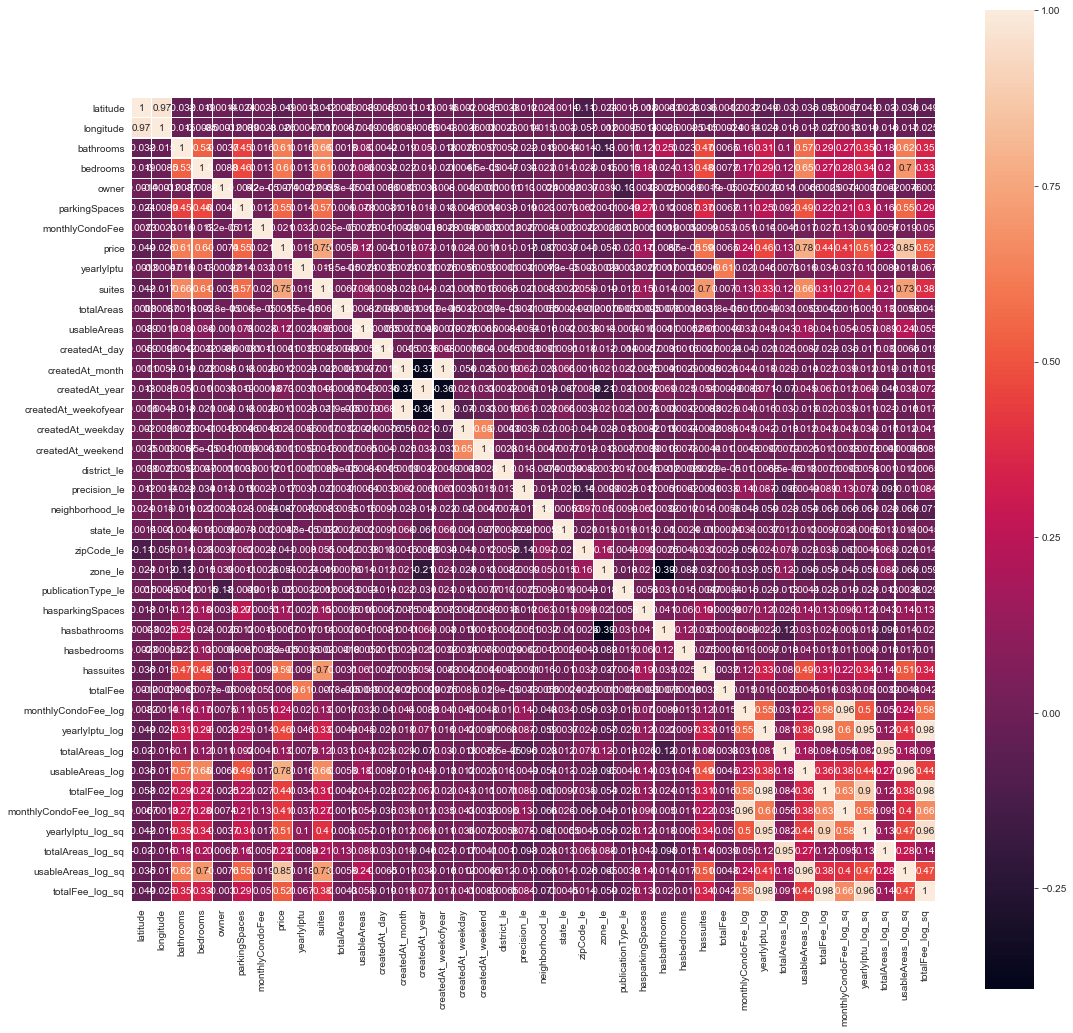

In [82]:
# Correlação de Pearson
cor_mat = train_sale.corr(method = 'pearson')

# Visualizando o grafico de heatmap
f, ax = plt.subplots(figsize=(18, 18))
sns.heatmap(cor_mat,linewidths=.1,ax=ax,square=True,cbar=True,annot=True)

### Skew
Skew (ou simetria) se refere a distribuição dos dados que é assumida ser normal ou gaussiana (bell curve). Muitos algoritmos de Machine Learning consideram que os dados possuem uma distribuição normal. Conhecendo a simetria dos dados, permite preparar e entregar o que o algoritmo espera receber, aumentado desta forma a acurácia do modelo preditivo.

In [83]:
# Verificando o skew de cada atributo
train_sale.skew()

latitude                  104.861684
longitude                 109.626972
bathrooms                  13.943720
bedrooms                    0.828185
owner                      61.404159
parkingSpaces              50.804989
monthlyCondoFee           203.531839
price                       0.668634
yearlyIptu                176.204077
suites                      1.245203
totalAreas                252.861914
usableAreas               177.601425
createdAt_day              -0.066212
createdAt_month            -0.079326
createdAt_year             -1.223994
createdAt_weekofyear       -0.071010
createdAt_weekday           0.090230
createdAt_weekend           2.053849
district_le              -146.219014
precision_le               -0.670161
neighborhood_le            -0.174198
state_le                  -17.670065
zipCode_le                  0.107204
zone_le                     3.213831
publicationType_le         -7.743959
hasparkingSpaces           -4.093301
hasbathrooms               -5.317837
h

# Feature Selection - Método Ensemble

As variaveis (atributos) presentes nos dados de treino tem grande influência na precisão e resultado do modelo preditivo. Atributos irrelevantes terão impacto negativo na performance, enquanto atributos colineares podem afetar o grau de acurácia do modelo. O Scikit-learn possui funções que automatizam o trabalho de extração e seleção de variáveis.

A etapa de Feature Selection é onde selecionamos as variaveis (atributos) que serão melhores candidatas a variáveis preditoras. O Feature Selection nos ajuda a reduzir o overfitting (quando o algoritmo aprende demais), aumenta a acurácia do modelo e reduz o tempo de treinamento.

Bagged Decision Trees, como o algoritmo RandomForest (esses são chamados de Métodos Ensemble), podem ser usados para estimar a importância de cada atributo. Esse método retorna um score para cada atributo. Quanto maior o score, maior a importância do atributo.

In [84]:
# Importância do Atributo com o Extra Trees Classifier

# Split features and labels (removi as colunas que nao foram convertidas para labelEncoder)
X = train_sale.drop(['price','district', 'precision','state', 
                     'zipCode', 'zone', 'publicationType','neighborhood'], axis=1)
y = train_sale['price']

# Aplicando a mesma escala nos dados
X = MinMaxScaler().fit_transform(X)

# Padronizando os dados (0 para a média, 1 para o desvio padrão)
X = StandardScaler().fit_transform(X)

# Criação do Modelo - Feature Selection
modeloETC = ExtraTreesRegressor()
modeloETC.fit(X, y)

# Convertendo o resultado em um dataframe
feature_importance_df = pd.DataFrame(train_sale.columns,columns=['Feature'])
feature_importance_df['importance'] = pd.DataFrame(modeloETC.feature_importances_.astype(float))

# Realizando a ordenacao por Importancia (Maior para Menor)
result = feature_importance_df.sort_values('importance',ascending=False)
print(result)

                   Feature    importance
27         neighborhood_le  2.285555e-01
37     monthlyCondoFee_log  1.576623e-01
8                bathrooms  1.179798e-01
32        hasparkingSpaces  9.551633e-02
29              zipCode_le  7.230582e-02
10                   owner  4.223738e-02
1                 latitude  3.981289e-02
5                    state  3.366096e-02
3                precision  2.675439e-02
6                  zipCode  2.607617e-02
0                 district  2.096719e-02
33            hasbathrooms  2.093902e-02
21          createdAt_year  1.797444e-02
34             hasbedrooms  1.766174e-02
35               hassuites  1.225760e-02
30                 zone_le  1.121039e-02
2                longitude  1.000190e-02
38          yearlyIptu_log  9.589888e-03
19           createdAt_day  7.882181e-03
36                totalFee  4.294578e-03
18             usableAreas  2.727653e-03
13                   price  2.666581e-03
11           parkingSpaces  2.613024e-03
15         publi

Visualizando a importancia das variaveis

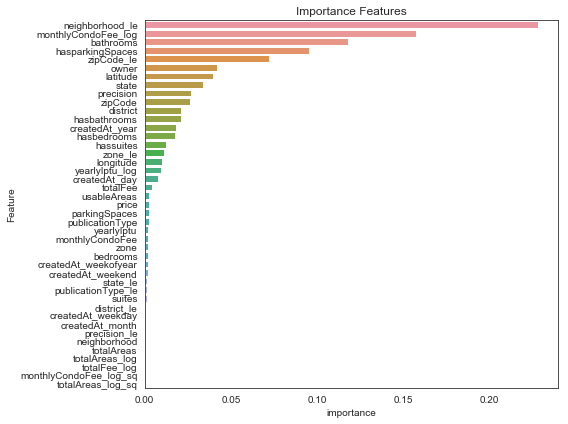

In [85]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:43].index)

best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(8,6))
sns.barplot(x="importance",
           y="Feature",
           data=best_features.sort_values(by="importance",
                                          ascending=False))
plt.title('Importance Features')
plt.tight_layout()

In [86]:
# Removendo algumas colunas do dataset com baixissima colinearidade
train_sale.drop(columns = ["state",
                           "createdAt_weekend",
                           "owner",
                           "district",
                           "totalFee_log_sq"
                          ], inplace = True) 

# Removendo do dataset de teste
test.drop(columns = ["state",
                     "createdAt_weekend",
                     "owner",
                     "district",
                     "totalFee_log_sq"
                    ], inplace = True) 

# Criação e Validação dos Modelos de Machine Learning

## Algumas considerações deste processo:
- **Cross Validation:** Estou usando 5-fold cross-validation
- **Models:** Em cada passada do cross-validation eu treino 4 modelos (gradient boosting, random forest, xgboost, lightgbm regressors)
- **Stacking:** Eu também treinei um modelo StackingCVRegressor otimizado usando xgboost
- **Otimizing:** Selecionei o modelo Light Gradient Boosting Regressor para aplicar otimização de hyperparametros

In [87]:
# Fazendo uma limpeza na memoria
gc.collect()

19866

Normalização e Padronização de features numericas

In [88]:
# Split features and labels
X = train_sale.drop(['price', 'precision', 'zipCode', 'zone', 'publicationType', 'neighborhood'],axis=1)
y = train_sale['price']

# Aplicando a mesma escala nos dados
X = MinMaxScaler().fit_transform(X)

# Padronizando os dados (0 para a média, 1 para o desvio padrão)
X = StandardScaler().fit_transform(X)

In [89]:
# Verificando o shape apos o split entre feature e target
X.shape, y.shape

((64146, 36), (64146,))

In [90]:
# Setup cross validation folds
kf = KFold(n_splits=6, random_state=2019, shuffle=True)
scoresRMSLE = {}

### Root Mean Squared Error (RMSE)

Essa é uma excelente métrica para modelos de regressão, além de ser muito fácil de interpretar. A Raiz Quadrada do Erro Quadrático Médio — ou simplesmente RMSE em inglês — nada mais é que a diferença entre o valor que foi previsto pelo seu modelo e o valor real que foi observado.
Por exemplo, imagine que você está construindo um modelo para prever preço de casas. Esse modelo deveria ter previsto o valor de 100 mil para um exemplo no seu conjunto, mas ele previu 99 mil: esse -1 mil de diferença é o erro do seu modelo. Agora é só repetir esse processo para todo seu conjunto de treino ou teste, elevar o erro ao quadrado, tirar a média de todos os valores do conjunto e, por fim, calcular a raiz quadrada.

In [91]:
# Defini a metrica de validacao (RMSE)
def cv_rmse(model, X, y):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=kf))
    return (rmse)

def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

Nessa parte adicionei varios modelos para comparacao. A principio utilizei os parametros default de cada modelo.

In [92]:
# Light Gradient Boosting Regressor
lightgbm = LGBMRegressor()

# XGBoost Regressor
xgboost = XGBRegressor(objective='reg:squarederror')

# Gradient Boosting Regressor
gbr = GradientBoostingRegressor()  

# Random Forest Regressor
rf = RandomForestRegressor()

# Stack up all the models above, optimized using xgboost
stack_gen = StackingCVRegressor(regressors=(lightgbm, xgboost, gbr, rf),
                                meta_regressor=xgboost,
                                random_state=2019,
                                use_features_in_secondary=True)


In [93]:
# Verificando a acuracia com a métrica RMSE
resRMSE = cv_rmse(lightgbm, X, y)
print("RMSE lightgbm: {:.4f} ({:.4f})".format(resRMSE.mean(), resRMSE.std()))
scoresRMSLE['lgb'] = (round(resRMSE.mean(),3), resRMSE.std())

RMSE lightgbm: 0.1911 (0.0026)


In [94]:
# Verificando a acuracia com a métrica RMSE
resRMSE = cv_rmse(xgboost, X, y)
print("RMSE xgboost: {:.4f} ({:.4f})".format(resRMSE.mean(), resRMSE.std()))
scoresRMSLE['xgb'] = (round(resRMSE.mean(),3), resRMSE.std())

RMSE xgboost: 0.2180 (0.0018)


In [95]:
# Verificando a acuracia com a métrica RMSE
resRMSE = cv_rmse(gbr, X, y)
print("RMSE gbr: {:.4f} ({:.4f})".format(resRMSE.mean(), resRMSE.std()))
scoresRMSLE['gbr'] = (round(resRMSE.mean(),3), resRMSE.std())

RMSE gbr: 0.2180 (0.0025)


In [96]:
# Verificando a acuracia com a métrica RMSE
resRMSE = cv_rmse(rf, X, y)
print("RMSE rf: {:.4f} ({:.4f})".format(resRMSE.mean(), resRMSE.std()))
scoresRMSLE['rf'] = (resRMSE.mean(), resRMSE.std())

RMSE rf: 0.1811 (0.0036)


In [97]:
# Verificando a acuracia com a métrica RMSE
resRMSE = cv_rmse(stack_gen, X, y)
print("RMSE stack_gen: {:.4f} ({:.4f})".format(resRMSE.mean(), resRMSE.std()))
scoresRMSLE['stack_gen'] = (resRMSE.mean(), resRMSE.std())

RMSE stack_gen: 0.1755 (0.0033)


# Otimização dos Modelos - Ajuste de Parâmetros

### Tree-structured Parzen Estimator

In [98]:
# Define os hyperparametros
hyper_space = {'n_estimators': 1000 + hp.randint('n_estimators', 1500),
               'max_depth':  hp.choice('max_depth', [4, 5, 8, -1]),
               'num_leaves': hp.choice('num_leaves', [15, 31, 63, 127]),
               'subsample': hp.uniform('subsample', 0.6, 1.0),
               'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 1.0)}

In [99]:
def evaluate(params, X, y):
    
    # Inicializa o modelo
    model = LGBMRegressor(boosting='gbdt', n_jobs=-1, random_state=2019)
    
    # Configura os hyperparametros
    model.set_params(**params)
    
    # Calcula o score
    scores = cv_rmse(model, X, y)
    #scores = np.sqrt(-cross_val_score(estimator=est, X=X, y=y, scoring='neg_mean_squared_error', cv=kf))
    score = np.mean(scores)
 
    return score
 
# Objetivo em minimizar o erro
hyperopt_objective = lambda params: (-1.0) * evaluate(params, X, y)

In [100]:
# Trail
trials = Trials()
 
# Configura os parametros do algoritmo
algo = partial(tpe.suggest, n_startup_jobs=20, gamma=0.25, n_EI_candidates=24)
 
# Fit Tree Parzen Estimator
best_vals = fmin(hyperopt_objective, 
                 space=hyper_space,
                 algo=algo, 
                 max_evals=60, 
                 trials=trials,
                 rstate=np.random.RandomState(seed=2019))
 
# Apresenta os melhores parametros
best_params = space_eval(hyper_space, best_vals)
print("Melhores Parametros: " + str(best_params))
 
# Apresenta o melhor score
scores = [-trial['result']['loss'] for trial in trials.trials]
scoresRMSLE['lgb_otm'] = (round(np.max(scores),2), (np.max(scores).std()))
print("RMSE lgb_otm: " + str(np.max(scores)))

# Apresenta o tempo de execução do treinamento
tdiff = trials.trials[-1]['book_time'] - trials.trials[0]['book_time']
print("ELAPSED TIME: " + str(tdiff.total_seconds() / 60))

100%|██████████| 60/60 [31:36<00:00, 31.05s/it, best loss: -0.17816660223912742] 
Melhores Parametros: {'colsample_bytree': 0.718009846032977, 'max_depth': 4, 'n_estimators': 1012, 'num_leaves': 63, 'subsample': 0.7070708987996427}
RMSE lgb_otm: 0.17816660223912742
ELAPSED TIME: 31.075683333333334


# Visualizando a performance dos modelos

In [101]:
scoresRMSLE

{'lgb': (0.191, 0.0025540532282748297),
 'xgb': (0.218, 0.0018244879717077844),
 'gbr': (0.218, 0.0025300830356369455),
 'rf': (0.181052200332695, 0.003581304449991042),
 'stack_gen': (0.1754544509931819, 0.003294333132364159),
 'lgb_otm': (0.18, 0.0)}

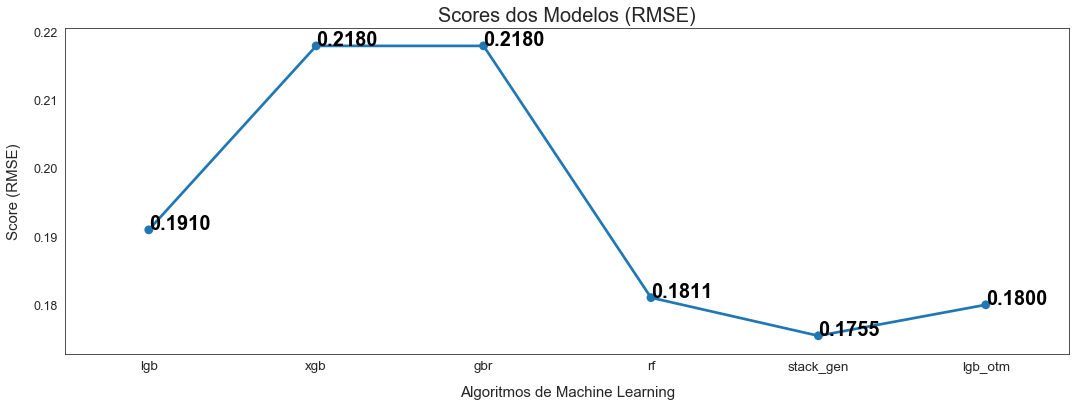

In [102]:
# Plot com a previsao de cada modelo usando a metrica RMSLE
sns.set_style("white")
fig = plt.figure(figsize=(18, 6))

ax = sns.pointplot(x=list(scoresRMSLE.keys()), y=[resRMSE for resRMSE, _ in scoresRMSLE.values()], markers=['o'], linestyles=['-'])
for i, resRMSE in enumerate(scoresRMSLE.values()):
    ax.text(i, resRMSE[0] , '{:.4f}'.format(resRMSE[0]), horizontalalignment='left', color='black', weight='semibold', size='20')

plt.ylabel('Score (RMSE)', size=15, labelpad=12.5)
plt.xlabel('Algoritmos de Machine Learning', size=15, labelpad=12.5)
plt.tick_params(axis='x', labelsize=13.5)
plt.tick_params(axis='y', labelsize=12.5)

plt.title('Scores dos Modelos (RMSE)', size=20)

plt.show()

# Agrupando Bairros por Preco de Venda

In [103]:
# Selecionando somente as colunas 'bairro' e 'preco' para aplicar clusterizacao
X_cluster = train_sale[['neighborhood_le','price']]

# Aplicando a mesma escala nos dados
X_cluster = MinMaxScaler().fit_transform(X_cluster)

# Padronizando os dados (0 para a média, 1 para o desvio padrão)
X_cluster = StandardScaler().fit_transform(X_cluster)

In [104]:
# Clusterizando o dataset (4 cluster)
kmeans = KMeans(n_clusters=4, random_state=2019).fit(X_cluster)
labels = kmeans.labels_

# Adicionando a coluna cluster no dataset
train_sale['clusters'] = labels

Text(24.808038194444443, 0.5, 'Price')

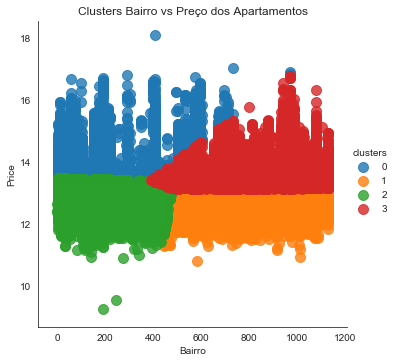

In [105]:
#Scatter plot dos clusters
sns.lmplot('neighborhood_le', 'price', 
           data=train_sale, 
           fit_reg=False, 
           hue="clusters",  
           scatter_kws={"marker": "D", 
                        "s": 100})
plt.title('Clusters Bairro vs Preço dos Apartamentos')
plt.xlabel('Bairro')
plt.ylabel('Price')

## Visualizando os bairros centroides dos clusters

In [106]:
train_sale['price_ori'] = np.floor(np.expm1(train_sale['price']))

In [107]:
# Agrupar os bairros por cluster (trazendo o valor medio)
q1 = """SELECT neighborhood, round(avg(price_ori),2) 
          FROM train_sale
         GROUP BY clusters"""
print(ps.sqldf(q1, locals()))

        neighborhood  round(avg(price_ori),2)
0            Paraíso               1945527.65
1  Vila Moinho Velho                304503.13
2    Bosque da Saúde                349320.61
3       Vila Olímpia               1048227.07


In [108]:
# Verificando a triangulação dos clusters considerando o preço medio de cada um
Image(url = 'images/cluster_map.png')

# Avaliando modelo por cluster

In [109]:
cluster_0 = train_sale[(train_sale['clusters'] == 0)]
cluster_1 = train_sale[(train_sale['clusters'] == 1)]
cluster_2 = train_sale[(train_sale['clusters'] == 2)]
cluster_3 = train_sale[(train_sale['clusters'] == 3)]

scoresCluster = {}

In [110]:
# Cluster 0

# Split features and labels
X_c0 = cluster_0.drop(['price','precision','zipCode','zone','publicationType','neighborhood','clusters'],axis=1)
y_c0 = cluster_0['price']

X_c0 = MinMaxScaler().fit_transform(X_c0)
X_c0 = StandardScaler().fit_transform(X_c0)

# Fit do modelo
model_c0 = stack_gen.fit(np.array(X_c0), np.array(y_c0))
y_pred_c0 = model_c0.predict(X_c0)

score_c0 = rmsle(y_c0, y_pred_c0)
print('RMSLE score Cluster 0:')
print(score_c0)

# Adiciona o score para apresentar no plot
scoresCluster['Cluster 0'] = round(score_c0,4)

RMSLE score Cluster 0:
0.00762364479013223


In [111]:
# Cluster 1

# Split features and labels
X_c1 = cluster_1.drop(['price','precision','zipCode','zone','publicationType','neighborhood','clusters'],axis=1)
y_c1 = cluster_1['price']

X_c1 = MinMaxScaler().fit_transform(X_c1)
X_c1 = StandardScaler().fit_transform(X_c1)

# Fit do modelo
model_c1 = stack_gen.fit(np.array(X_c1), np.array(y_c1))
y_pred_c1 = model_c1.predict(X_c1)

score_c1 = rmsle(y_c1, y_pred_c1)
print('RMSLE score Cluster 1:')
print(score_c1)

# Adiciona o score para apresentar no plot
scoresCluster['Cluster 1'] = round(score_c1,4)

RMSLE score Cluster 1:
0.0036763856960292727


In [112]:
# Cluster 2

# Split features and labels
X_c2 = cluster_2.drop(['price','precision','zipCode','zone','publicationType','neighborhood','clusters'],axis=1)
y_c2 = cluster_2['price']

X_c2 = MinMaxScaler().fit_transform(X_c2)
X_c2 = StandardScaler().fit_transform(X_c2)

# Fit do modelo
model_c2 = stack_gen.fit(np.array(X_c2), np.array(y_c2))
y_pred_c2 = model_c2.predict(X_c2)

score_c2 = rmsle(y_c2, y_pred_c2)
print('RMSLE score Cluster 2:')
print(score_c2)

# Adiciona o score para apresentar no plot
scoresCluster['Cluster 2'] = round(score_c2,4)

RMSLE score Cluster 2:
0.005587502235812906


In [113]:
# Cluster 3

# Split features and labels
X_c3 = cluster_3.drop(['price','precision','zipCode','zone','publicationType','neighborhood','clusters'],axis=1)
y_c3 = cluster_3['price']

X_c3 = MinMaxScaler().fit_transform(X_c3)
X_c3 = StandardScaler().fit_transform(X_c3)

# Fit do modelo
model_c3 = stack_gen.fit(np.array(X_c3), np.array(y_c3))
y_pred_c3 = model_c3.predict(X_c3)

score_c3 = rmsle(y_c3, y_pred_c3)
print('RMSLE score Cluster 3:')
print(score_c3)

# Adiciona o score para apresentar no plot
scoresCluster['Cluster 3'] = round(score_c3,4)

RMSLE score Cluster 3:
0.005885661489287753


In [114]:
scoresCluster

{'Cluster 0': 0.0076,
 'Cluster 1': 0.0037,
 'Cluster 2': 0.0056,
 'Cluster 3': 0.0059}

## Visualizando a performance do modelo por Clusters

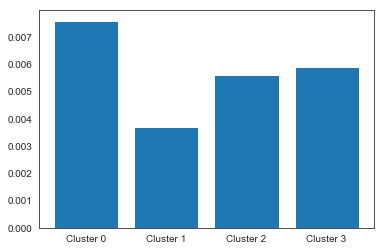

In [115]:
plt.bar(range(len(scoresCluster)), list(scoresCluster.values()), align='center')
plt.xticks(range(len(scoresCluster)), list(scoresCluster.keys()))
plt.show()

# Validando o melhor modelo nos dados de teste

In [116]:
# Separando o dataset em dados de treino e teste (considerando a proporção 70/30)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2019)

# Fit do modelo com os dados de treino
stack_gen_model = stack_gen.fit(np.array(X_train), np.array(y_train))

# Fazendo as previsoes nos dados de teste
y_pred = stack_gen_model.predict(np.array(X_test))
 
# Previsão
score = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE nos dados de Teste: {}".format(score))

RMSE nos dados de Teste: 0.17893628145030038


### Podemos observar nos gráficos de comparacao acima que o modelo StackingCVRegressor tem a melhor performance (combinando varios modelos), com um RMSLE de 0,1757 nos dados de treino e 0,1783 nos dados de teste (aplicado aos dados de treino a proporção de 30% para teste). Este é o modelo que usarei para fazer as previsões finais.

# Trabalhando com o dataset de Teste

In [117]:
# Visualizando os dados de teste já completamente tratados para aplicar o modelo de ML
test.head(5)

,latitude,longitude,precision,neighborhood,zipCode,zone,bathrooms,bedrooms,parkingSpaces,monthlyCondoFee,yearlyIptu,publicationType,suites,totalAreas,usableAreas,createdAt_day,createdAt_month,createdAt_year,createdAt_weekofyear,createdAt_weekday,district_le,precision_le,neighborhood_le,state_le,zipCode_le,zone_le,publicationType_le,hasparkingSpaces,hasbathrooms,hasbedrooms,hassuites,totalFee,monthlyCondoFee_log,yearlyIptu_log,totalAreas_log,usableAreas_log,totalFee_log,monthlyCondoFee_log_sq,yearlyIptu_log_sq,totalAreas_log_sq,usableAreas_log_sq
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
89224365f8,-23.557225,-46.662765,GEOMETRIC_CENTER,Consolação,01415000,Centro,1,1,1,0.0,0.0,STANDARD,0,47.0,47.0,20,10,2015,43,1,0,1,115,1,365,0,1,1,1,1,0,0.0,0.009950,0.009950,3.871409,3.871409,0.009950,0.000099,0.000099,14.987810,14.987810
363731333f,-23.592852,-46.581879,ROOFTOP,Quinta da Paineira,03152155,Zona Leste,0,2,1,0.0,0.0,STANDARD,0,55.0,55.0,31,7,2018,31,1,0,4,477,1,1469,2,1,1,0,1,0,0.0,0.009950,0.009950,4.025530,4.025530,0.009950,0.000099,0.000099,16.204894,16.204894
6e6283378a,-23.493609,-46.638456,ROOFTOP,Chora Menino,02461000,None,3,3,2,686.0,0.0,STANDARD,1,0.0,92.0,25,1,2018,4,3,0,4,60,1,1037,1,1,1,1,1,1,0.0,6.532349,0.009950,0.009950,4.532707,0.009950,42.671581,0.000099,0.000099,20.545433
4c29a27f44,-23.607981,-46.686180,GEOMETRIC_CENTER,Brooklin Paulista,04561003,None,4,3,3,770.0,368.0,STANDARD,3,145.0,145.0,27,4,2018,17,4,0,1,27,1,2974,1,1,1,1,1,1,283360.0,6.647701,5.910824,4.983675,4.983675,12.554477,44.191933,34.937837,24.837018,24.837018
7b16cf224b,-23.540604,-46.715088,ROOFTOP,Alto de Pinheiros,05468140,None,2,2,1,472.0,79.0,STANDARD,1,76.0,76.0,16,9,2018,37,6,0,4,9,1,3753,1,1,1,1,1,1,37288.0,6.159117,4.382152,4.343935,4.343935,10.526454,37.934716,19.203253,18.869774,18.869774


In [118]:
# Configurando o dataset de teste, retirando algumas colunas 
X_final = test.drop(['precision', 'zipCode', 'zone', 'publicationType', 'neighborhood'],axis=1)
X_final = MinMaxScaler().fit_transform(X_final)
X_final = StandardScaler().fit_transform(X_final)

# Fazendo as previsoes de preco no dataset de teste
previsoes = np.expm1(stack_gen_model.predict(np.array(X_final)))

Gerando o arquivo de teste com as colunas 'id' e 'price' (indica a previsao do modelo)

In [119]:
#Gerando Arquivo de Submissao
submission = pd.DataFrame({
    "id": test.index, 
    "price": previsoes
})

In [120]:
# Salvando o resultado das previsoes em um arquivo .csv
submission.to_csv('data/test_new.csv', index=False)